In [12]:
import pandas as pd
import pathlib
import numpy as np

## Load Data

In [13]:
raw_data_dir = pathlib.Path("../../data/raw/peggy_2")

trans_res_path = raw_data_dir.joinpath('skyline raw data_heavy_dilute.csv')
trans_res_df_raw = pd.read_csv(trans_res_path)
trans_res_df_raw.columns = trans_res_df_raw.columns.map(str.lower)
trans_res_df_raw.head()

,peptide,protein,replicate,precursor mz,precursor charge,product mz,product charge,fragment ion,area
0,ALVGPGSPPR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,475.774534,2,475.774534,2,precursor,225151600
1,ALVGPGSPPR,sp|Q12809|KCNH2_HUMAN,D0_2ul_27,475.774534,2,475.774534,2,precursor,157798592
2,ALVGPGSPPR,sp|Q12809|KCNH2_HUMAN,D0_2ul_37,475.774534,2,475.774534,2,precursor,210296016
3,ALVGPGSPPR,sp|Q12809|KCNH2_HUMAN,D0_2ul_7,475.774534,2,475.774534,2,precursor,210075488
4,ALVGPGSPPR,sp|Q12809|KCNH2_HUMAN,D1_2ul_14,475.774534,2,475.774534,2,precursor,44952


In [14]:

trans_res_df_raw.peptide.unique()

array(['ALVGPGSPPR', 'SAPGQLPSPR', 'AHSLNPDASGSSCSLAR', 'ASSADDIEAMR',
       'SGLLNSTSDSDLVR'], dtype=object)

## Compute Area ratio

In [15]:

def grp_area_ratio_n_area_cols(grouped_df:pd.DataFrame, denominator_is_min=True):
    
    """compute the ratio of areas with higer precursor mz value as numerator."""

    df = grouped_df[['precursor mz', 'area']].copy()
    
    df = df.sort_values(by='precursor mz', ascending=True)
    
    area_min, area_max  =  df['area'].iloc[0], df['area'].iloc[1]
    if denominator_is_min:
        # area_ratio = df['area'].iloc[1] / df['area'].iloc[0]
        if area_min == 0:
            area_min = 1.0
        area_ratio = area_max / area_min
    else:
        if area_max == 0:
            area_max = 1.0
        area_ratio = area_min / area_max
        

    col_vals = {'area_ratio': area_ratio, 'area_min':area_min, 'area_max':area_max}

    return pd.Series(col_vals)

cols_to_group_by = ['peptide', 'protein', 'replicate', 'product charge', 'fragment ion']
# df_area_ratio = trans_res_df_raw.groupby(cols_to_group_by).apply(grp_area_ratio).reset_index(name='area_ratio')
df_area_ratio = trans_res_df_raw.groupby(cols_to_group_by).apply(grp_area_ratio_n_area_cols,).reset_index()


# df_area_ratio = df_area_ratio[df_area_ratio['fragment ion'] == 'precursor']  # select only precursor
print(df_area_ratio.shape)
df_area_ratio.head()

(1120, 8)


,peptide,protein,replicate,product charge,fragment ion,area_ratio,area_min,area_max
0,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,b2,0.000000,348365.0,0.0
1,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,b3,0.000000,213945.0,0.0
2,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,y10,0.000000,249316.0,0.0
3,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,y12,0.000000,1203510.0,0.0
4,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,2,precursor,0.007892,46716648.0,368708.0


In [16]:
np.isinf(df_area_ratio.area_ratio).sum()

0

## Get peptide Dilution Conc.

In [17]:



df_peptide_dilution_conc = pd.read_csv(raw_data_dir.joinpath('peptide_dilution_conc_peggy.csv'))
raw_dilution_col_names = df_peptide_dilution_conc.columns[1:]

df_peptide_dilution_conc = df_peptide_dilution_conc.melt(id_vars='Peptides', value_vars=raw_dilution_col_names, 
                                                        var_name='dilution', value_name='heavy_conc')
df_peptide_dilution_conc['dilution'] = df_peptide_dilution_conc['dilution'].apply(lambda x: x[:2])
peptide_dilution_name_col = 'peptide_dilution_name'
df_peptide_dilution_conc[peptide_dilution_name_col] = df_peptide_dilution_conc['Peptides'] + '_' + \
                                                    df_peptide_dilution_conc['dilution'] 
df_peptide_dilution_conc.head()


,Peptides,dilution,heavy_conc,peptide_dilution_name
0,ALVGPGSPPR,D1,49.9,ALVGPGSPPR_D1
1,ASSADDIEAMR,D1,61.1,ASSADDIEAMR_D1
2,SGLLNSTSDSDLVR,D1,76.6,SGLLNSTSDSDLVR_D1
3,SAPGQLPSPR,D1,53.0,SAPGQLPSPR_D1
4,AHSLNPDASGSSCSLAR,D1,90.5,AHSLNPDASGSSCSLAR_D1


### Merge data

In [18]:
df_area_ratio

,peptide,protein,replicate,product charge,fragment ion,area_ratio,area_min,area_max
0,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,b2,0.000000,3.483650e+05,0.0
1,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,b3,0.000000,2.139450e+05,0.0
2,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,y10,0.000000,2.493160e+05,0.0
3,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,y12,0.000000,1.203510e+06,0.0
4,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,2,precursor,0.007892,4.671665e+07,368708.0
...,...,...,...,...,...,...,...,...
1115,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,1,y3,0.000000,1.496066e+06,0.0
1116,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,1,y5,0.007541,3.495830e+06,26362.0
1117,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,2,precursor,0.016787,1.812807e+09,30431842.0
1118,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,2,precursor [M+1],0.032604,1.304090e+09,42518064.0


In [19]:
def get_dilution_from_replicate(rep_string:str):
    """Get the dilution symbol from the replicate name."""

    str_to_check = rep_string.split('_')[0]
    if str_to_check.startswith('col'):
        dilution = 'D0'
    else:
        dilution = str_to_check

    return dilution

def get_peptide_dilution_comb(row):
    """function to create a new column from peptide and dilution name."""
    peptide = row['peptide']
    replicate  = row['replicate']
    dilution = get_dilution_from_replicate(rep_string=replicate)

    return peptide + '_' + dilution

df_area_ratio[peptide_dilution_name_col] = df_area_ratio.apply(get_peptide_dilution_comb, axis=1)



df_area_ratio_conc = pd.merge(df_area_ratio, right=df_peptide_dilution_conc, how='left', 
                              on=peptide_dilution_name_col, suffixes=('', '_y'))
df_area_ratio_conc.drop(df_area_ratio_conc.filter(regex='_y$').columns, axis=1, inplace=True)
df_area_ratio_conc = df_area_ratio_conc.dropna(axis=0) # drop nan
# drop inf
df_area_ratio_conc.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_area_ratio_conc.dropna(subset=["area_ratio"], how="all", inplace=True)

# def get_rep_plot_cat(rep_val:str):
#     """Get the plot category (C18_SDS, C18_SDC, etc..)."""

#     select_elements = rep_val.split('_')[1:3]

#     cat = '_'.join(select_elements)
#     return cat

# TODO: - reverse x and y in plots: ratio:y, conc: x
#- TODO: further break replicate into 2 groups as shown in the excel, the greens are one group and the white is another.
def get_rep_plot_cat(row):
    """Get the plot category (C18_SDS, C18_SDC, etc..)."""

    replicate = row['replicate']
    peptide = row['peptide']
    fragment_ion = row['fragment ion']

    rep_elements = replicate.split('_')[0:3]

    cat_name = [peptide] + [fragment_ion] #+ rep_elements
    cat_name = '_'.join(cat_name)
    return cat_name


# create plot categories
df_area_ratio_conc['plot_cat'] = df_area_ratio_conc.apply(get_rep_plot_cat, axis=1)

df_area_ratio_conc['plot_cat_grp'] = df_area_ratio_conc['plot_cat'].apply(lambda x: '_'.join(x.split('_')[:-2]))
df_area_ratio_conc['order_comp'] = df_area_ratio_conc['replicate'].apply(lambda x: x.split('_')[-1])
df_area_ratio_conc.head()

,peptide,protein,replicate,product charge,fragment ion,area_ratio,area_min,area_max,peptide_dilution_name,Peptides,dilution,heavy_conc,plot_cat,plot_cat_grp,order_comp
0,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,b2,0.000000,348365.0,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,D0,0.0,AHSLNPDASGSSCSLAR_b2,,17
1,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,b3,0.000000,213945.0,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,D0,0.0,AHSLNPDASGSSCSLAR_b3,,17
2,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,y10,0.000000,249316.0,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,D0,0.0,AHSLNPDASGSSCSLAR_y10,,17
3,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,y12,0.000000,1203510.0,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,D0,0.0,AHSLNPDASGSSCSLAR_y12,,17
4,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,2,precursor,0.007892,46716648.0,368708.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,D0,0.0,AHSLNPDASGSSCSLAR_precursor,,17


In [20]:
from scipy.stats import rankdata

def get_order(grouped_df):

    vals_to_order = list(map(int, grouped_df['order_comp'].values))
    ranks = np.int8(rankdata(vals_to_order))

    grouped_df['order'] = ranks

    return grouped_df
    
df_area_ratio_conc['rep_partial'] = df_area_ratio_conc['replicate'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_area_ratio_conc['plot_cat_grp'] = df_area_ratio_conc['plot_cat'] + df_area_ratio_conc['rep_partial']
                 
# df_area_ratio_conc['rep_partial_last'] = df_area_ratio_conc['replicate'].apply(lambda x: x.split('_')[-1])

order = df_area_ratio_conc.groupby('plot_cat_grp').apply(get_order)['order']

df_area_ratio_conc['plot_cat'] = df_area_ratio_conc['plot_cat'] + '_' + list(map(str, list(order)))
df_area_ratio_conc.sort_values(by=['plot_cat'])

,peptide,protein,replicate,product charge,fragment ion,area_ratio,area_min,area_max,peptide_dilution_name,Peptides,dilution,heavy_conc,plot_cat,plot_cat_grp,order_comp,rep_partial
84,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D3_2ul_12,1,b2,1.504151,343159.0,516163.0,AHSLNPDASGSSCSLAR_D3,AHSLNPDASGSSCSLAR,D3,5.6600,AHSLNPDASGSSCSLAR_b2_1,AHSLNPDASGSSCSLAR_b2D3_2ul,12,D3_2ul
112,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D4_2ul_11,1,b2,0.124657,280313.0,34943.0,AHSLNPDASGSSCSLAR_D4,AHSLNPDASGSSCSLAR,D4,1.4100,AHSLNPDASGSSCSLAR_b2_1,AHSLNPDASGSSCSLAR_b2D4_2ul,11,D4_2ul
217,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,1,b2,0.000000,361965.0,0.0,AHSLNPDASGSSCSLAR_D7,AHSLNPDASGSSCSLAR,D7,0.0221,AHSLNPDASGSSCSLAR_b2_1,AHSLNPDASGSSCSLAR_b2D7_2ul,8,D7_2ul
140,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D5_2ul_10,1,b2,0.000000,337988.0,0.0,AHSLNPDASGSSCSLAR_D5,AHSLNPDASGSSCSLAR,D5,0.3540,AHSLNPDASGSSCSLAR_b2_1,AHSLNPDASGSSCSLAR_b2D5_2ul,10,D5_2ul
56,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D2_2ul_13,1,b2,0.000000,1.0,0.0,AHSLNPDASGSSCSLAR_D2,AHSLNPDASGSSCSLAR,D2,22.6000,AHSLNPDASGSSCSLAR_b2_1,AHSLNPDASGSSCSLAR_b2D2_2ul,13,D2_2ul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D1_2ul_44,1,y5,5.984168,906100.0,5422255.0,SGLLNSTSDSDLVR_D1,SGLLNSTSDSDLVR,D1,76.6000,SGLLNSTSDSDLVR_y5_4,SGLLNSTSDSDLVR_y5D1_2ul,44,D1_2ul
913,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D0_2ul_37,1,y5,0.000000,419135.0,0.0,SGLLNSTSDSDLVR_D0,SGLLNSTSDSDLVR,D0,0.0000,SGLLNSTSDSDLVR_y5_4,SGLLNSTSDSDLVR_y5D0_2ul,37,D0_2ul
1081,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D6_2ul_39,1,y5,0.000000,1.0,0.0,SGLLNSTSDSDLVR_D6,SGLLNSTSDSDLVR,D6,0.0748,SGLLNSTSDSDLVR_y5_4,SGLLNSTSDSDLVR_y5D6_2ul,39,D6_2ul
1032,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D4_2ul_41,1,y5,0.000000,1.0,0.0,SGLLNSTSDSDLVR_D4,SGLLNSTSDSDLVR,D4,1.2000,SGLLNSTSDSDLVR_y5_4,SGLLNSTSDSDLVR_y5D4_2ul,41,D4_2ul


In [21]:
df_area_ratio_conc['plot_cat'].value_counts()

SGLLNSTSDSDLVR_y5_3                 8
ASSADDIEAMR_y4_1                    8
SGLLNSTSDSDLVR_precursor [M+1]_4    8
ASSADDIEAMR_b2_4                    8
SAPGQLPSPR_precursor_3              8
                                   ..
SGLLNSTSDSDLVR_y1_3                 8
SGLLNSTSDSDLVR_precursor [M+2]_3    8
SAPGQLPSPR_precursor [M+2]_1        8
SAPGQLPSPR_precursor [M+1]_3        8
ALVGPGSPPR_b1_4                     8
Name: plot_cat, Length: 140, dtype: int64

In [22]:
temp_df = df_area_ratio_conc.copy()
temp_df['rep_partial'] = temp_df['replicate'].apply(lambda x: '_'.join(x.split('_')[:-1]))
temp_df['rep_partial_last'] = temp_df['replicate'].apply(lambda x: x.split('_')[-1])

grp_df = temp_df.groupby(['plot_cat', 'rep_partial'])

In [23]:
temp_df.sort_values(by='plot_cat').head()

,peptide,protein,replicate,product charge,fragment ion,area_ratio,area_min,area_max,peptide_dilution_name,Peptides,dilution,heavy_conc,plot_cat,plot_cat_grp,order_comp,rep_partial,rep_partial_last
84,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D3_2ul_12,1,b2,1.504151,343159.0,516163.0,AHSLNPDASGSSCSLAR_D3,AHSLNPDASGSSCSLAR,D3,5.6600,AHSLNPDASGSSCSLAR_b2_1,AHSLNPDASGSSCSLAR_b2D3_2ul,12,D3_2ul,12
112,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D4_2ul_11,1,b2,0.124657,280313.0,34943.0,AHSLNPDASGSSCSLAR_D4,AHSLNPDASGSSCSLAR,D4,1.4100,AHSLNPDASGSSCSLAR_b2_1,AHSLNPDASGSSCSLAR_b2D4_2ul,11,D4_2ul,11
217,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,1,b2,0.000000,361965.0,0.0,AHSLNPDASGSSCSLAR_D7,AHSLNPDASGSSCSLAR,D7,0.0221,AHSLNPDASGSSCSLAR_b2_1,AHSLNPDASGSSCSLAR_b2D7_2ul,8,D7_2ul,8
140,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D5_2ul_10,1,b2,0.000000,337988.0,0.0,AHSLNPDASGSSCSLAR_D5,AHSLNPDASGSSCSLAR,D5,0.3540,AHSLNPDASGSSCSLAR_b2_1,AHSLNPDASGSSCSLAR_b2D5_2ul,10,D5_2ul,10
56,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D2_2ul_13,1,b2,0.000000,1.0,0.0,AHSLNPDASGSSCSLAR_D2,AHSLNPDASGSSCSLAR,D2,22.6000,AHSLNPDASGSSCSLAR_b2_1,AHSLNPDASGSSCSLAR_b2D2_2ul,13,D2_2ul,13


In [24]:

from scipy.stats import rankdata

def get_order(grouped_df):

    vals_to_order = list(map(int, grouped_df['order_comp'].values))
    ranks = np.int8(rankdata(vals_to_order))

    grouped_df['order'] = ranks

    return grouped_df
    
    

order = df_area_ratio_conc.groupby('plot_cat_grp').apply(get_order)['order']

df_area_ratio_conc['plot_cat'] = df_area_ratio_conc['plot_cat'] + '_' + list(map(str, list(order)))
df_area_ratio_conc.sort_values(by=['plot_cat'])

,peptide,protein,replicate,product charge,fragment ion,area_ratio,area_min,area_max,peptide_dilution_name,Peptides,dilution,heavy_conc,plot_cat,plot_cat_grp,order_comp,rep_partial
84,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D3_2ul_12,1,b2,1.504151,343159.0,516163.0,AHSLNPDASGSSCSLAR_D3,AHSLNPDASGSSCSLAR,D3,5.6600,AHSLNPDASGSSCSLAR_b2_1_1,AHSLNPDASGSSCSLAR_b2D3_2ul,12,D3_2ul
112,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D4_2ul_11,1,b2,0.124657,280313.0,34943.0,AHSLNPDASGSSCSLAR_D4,AHSLNPDASGSSCSLAR,D4,1.4100,AHSLNPDASGSSCSLAR_b2_1_1,AHSLNPDASGSSCSLAR_b2D4_2ul,11,D4_2ul
217,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,1,b2,0.000000,361965.0,0.0,AHSLNPDASGSSCSLAR_D7,AHSLNPDASGSSCSLAR,D7,0.0221,AHSLNPDASGSSCSLAR_b2_1_1,AHSLNPDASGSSCSLAR_b2D7_2ul,8,D7_2ul
140,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D5_2ul_10,1,b2,0.000000,337988.0,0.0,AHSLNPDASGSSCSLAR_D5,AHSLNPDASGSSCSLAR,D5,0.3540,AHSLNPDASGSSCSLAR_b2_1_1,AHSLNPDASGSSCSLAR_b2D5_2ul,10,D5_2ul
56,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D2_2ul_13,1,b2,0.000000,1.0,0.0,AHSLNPDASGSSCSLAR_D2,AHSLNPDASGSSCSLAR,D2,22.6000,AHSLNPDASGSSCSLAR_b2_1_1,AHSLNPDASGSSCSLAR_b2D2_2ul,13,D2_2ul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D1_2ul_44,1,y5,5.984168,906100.0,5422255.0,SGLLNSTSDSDLVR_D1,SGLLNSTSDSDLVR,D1,76.6000,SGLLNSTSDSDLVR_y5_4_4,SGLLNSTSDSDLVR_y5D1_2ul,44,D1_2ul
913,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D0_2ul_37,1,y5,0.000000,419135.0,0.0,SGLLNSTSDSDLVR_D0,SGLLNSTSDSDLVR,D0,0.0000,SGLLNSTSDSDLVR_y5_4_4,SGLLNSTSDSDLVR_y5D0_2ul,37,D0_2ul
1081,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D6_2ul_39,1,y5,0.000000,1.0,0.0,SGLLNSTSDSDLVR_D6,SGLLNSTSDSDLVR,D6,0.0748,SGLLNSTSDSDLVR_y5_4_4,SGLLNSTSDSDLVR_y5D6_2ul,39,D6_2ul
1032,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D4_2ul_41,1,y5,0.000000,1.0,0.0,SGLLNSTSDSDLVR_D4,SGLLNSTSDSDLVR,D4,1.2000,SGLLNSTSDSDLVR_y5_4_4,SGLLNSTSDSDLVR_y5D4_2ul,41,D4_2ul


In [25]:
df_area_ratio_conc['plot_cat'].value_counts()

AHSLNPDASGSSCSLAR_precursor [M+2]_3_3    8
SAPGQLPSPR_y4_3_3                        8
AHSLNPDASGSSCSLAR_b3_1_1                 8
SGLLNSTSDSDLVR_precursor_3_3             8
ALVGPGSPPR_precursor [M+2]_1_1           8
                                        ..
ASSADDIEAMR_precursor [M+2]_3_3          8
SAPGQLPSPR_precursor_3_3                 8
AHSLNPDASGSSCSLAR_precursor_2_2          8
SGLLNSTSDSDLVR_precursor_2_2             8
SAPGQLPSPR_y7_1_1                        8
Name: plot_cat, Length: 140, dtype: int64

In [26]:
df_area_ratio_conc['plot_cat'][:20]

0                  AHSLNPDASGSSCSLAR_b2_2_2
1                  AHSLNPDASGSSCSLAR_b3_2_2
2                 AHSLNPDASGSSCSLAR_y10_2_2
3                 AHSLNPDASGSSCSLAR_y12_2_2
4           AHSLNPDASGSSCSLAR_precursor_2_2
5     AHSLNPDASGSSCSLAR_precursor [M+1]_2_2
6     AHSLNPDASGSSCSLAR_precursor [M+2]_2_2
7                  AHSLNPDASGSSCSLAR_b2_3_3
8                  AHSLNPDASGSSCSLAR_b3_3_3
9                 AHSLNPDASGSSCSLAR_y10_3_3
10                AHSLNPDASGSSCSLAR_y12_3_3
11          AHSLNPDASGSSCSLAR_precursor_3_3
12    AHSLNPDASGSSCSLAR_precursor [M+1]_3_3
13    AHSLNPDASGSSCSLAR_precursor [M+2]_3_3
14                 AHSLNPDASGSSCSLAR_b2_4_4
15                 AHSLNPDASGSSCSLAR_b3_4_4
16                AHSLNPDASGSSCSLAR_y10_4_4
17                AHSLNPDASGSSCSLAR_y12_4_4
18          AHSLNPDASGSSCSLAR_precursor_4_4
19    AHSLNPDASGSSCSLAR_precursor [M+1]_4_4
Name: plot_cat, dtype: object

In [27]:
df_area_ratio_conc['plot_cat'].nunique()

140

## Get Linear Fit parameters

In [28]:
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt

def get_plot(data:pd.DataFrame, plot_cat:str, ax):

    cat_data = data[data['plot_cat'] == plot_cat].copy()
    # print(cat_data)

    # fig, ax = plt.subplots()
    cat_data.dropna(axis=0, inplace=True)

    y = cat_data['area_ratio'].values
    x = cat_data['heavy_conc'].values

    ax.scatter(x, y)

    x = x[:, np.newaxis]
    y = y[:, np.newaxis]

    model = linear_model.LinearRegression()

    model.fit(x, y)

    y_fit = model.predict(x)

    ax.plot(x.flatten(), y_fit.flatten())
    ax.set_title(plot_cat)
    
    return ax

def get_linear_fit(data:pd.DataFrame, plot_cat:str):

    cat_data = data[data['plot_cat'] == plot_cat].copy()
    # print(cat_data)

    # fig, ax = plt.subplots()
    cat_data.dropna(axis=0, inplace=True)

    y = cat_data['area_ratio'].values
    x = cat_data['heavy_conc'].values

    # non-linear regression
    x = 1/x
    valid_pts = np.where(~np.isnan(x) & ~np.isinf(x))[0]
    x = x[valid_pts]
    y = y[valid_pts]

    # ax.scatter(x, y)

    x = x[:, np.newaxis]
    y = y[:, np.newaxis]

    model = linear_model.LinearRegression()

    model.fit(x, y)

    y_fit = model.predict(x)

    # ax.plot(x.flatten(), y_fit.flatten())

    r2 = metrics.r2_score(y, y_fit)
    intercept = model.intercept_.squeeze()
    grad = model.coef_[0].squeeze()

    
    return (r2, intercept, grad)

plot_cats = df_area_ratio_conc['plot_cat'].unique()

# plot_df = df_area_ratio_conc[df_area_ratio_conc.peptide=='GGLEPINFQTAADQAR'] # get only one peptide
# plot_df = plot_df[[peptide_dilution_name_col, 'area_ratio', 'heavy_conc', 'plot_cat']]
plot_df = df_area_ratio_conc


cats = []
r2s = []
intercepts = []
grads = []

for cat in plot_cats:
    # print(cat)
    r2, intercept, grad = get_linear_fit(plot_df, cat)
    cats.append(cat)
    r2s.append(r2)
    intercepts.append(intercept)
    grads.append(grad)




df_plot_cat_fit_params = pd.DataFrame({'plot_cat':cats,
              'R2':r2s,
              'intercept':intercepts,
              'gradient':grads})




C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Aroge\anaco

## Plots

### plot by plot cat

C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


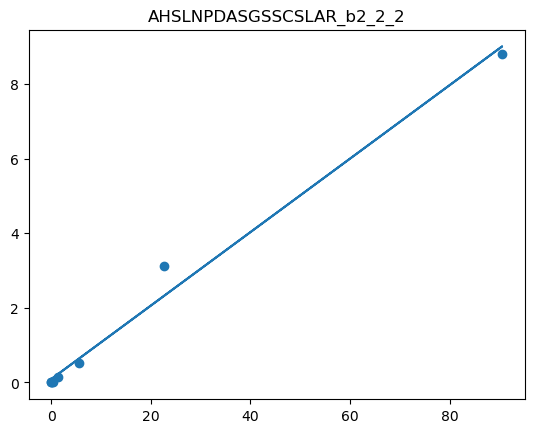

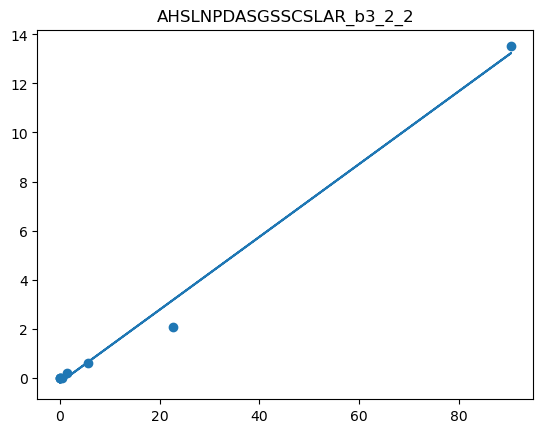

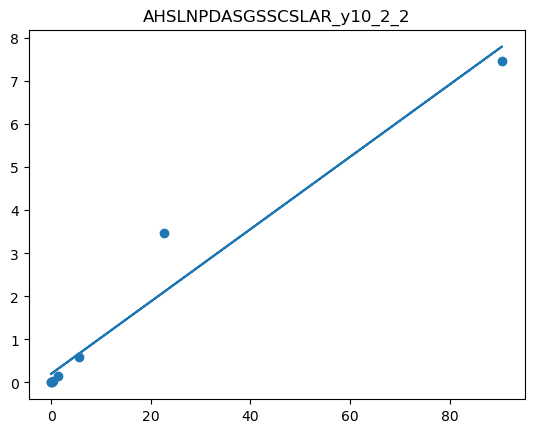

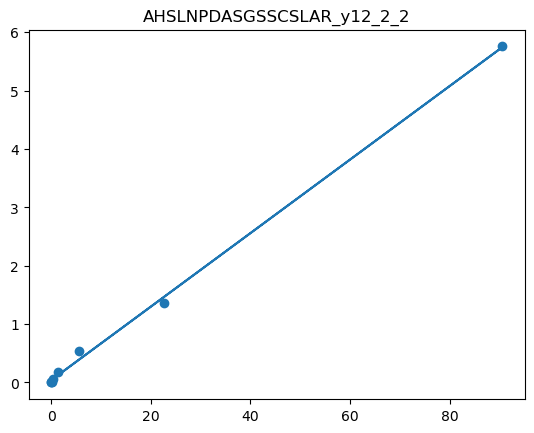

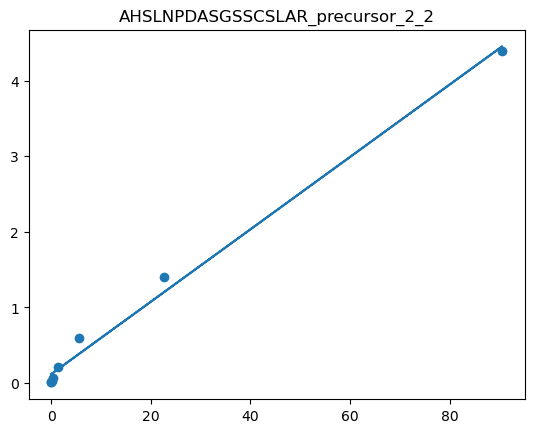

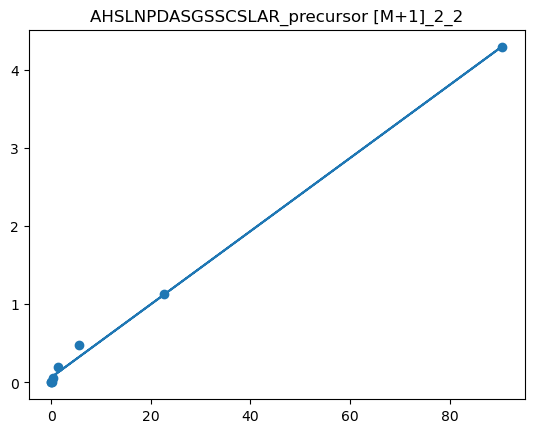

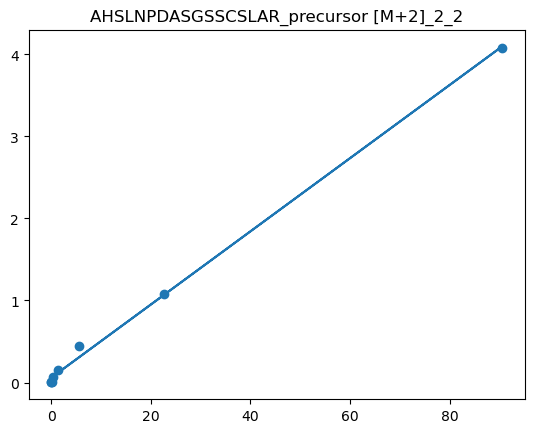

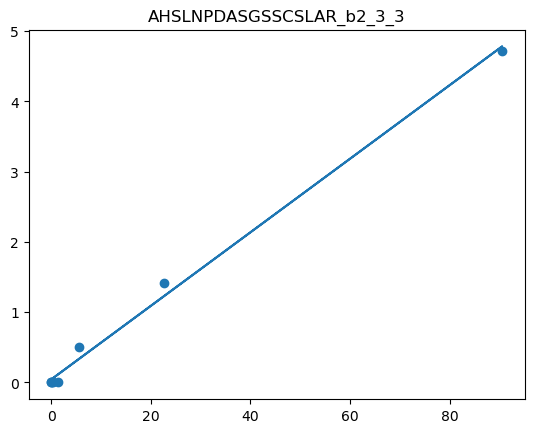

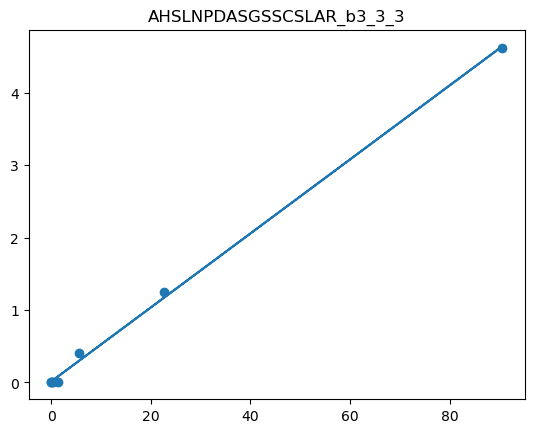

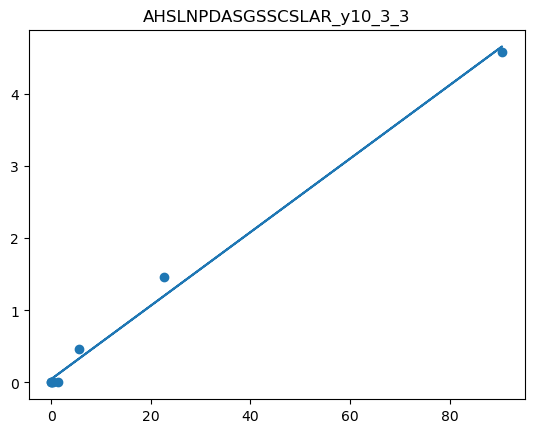

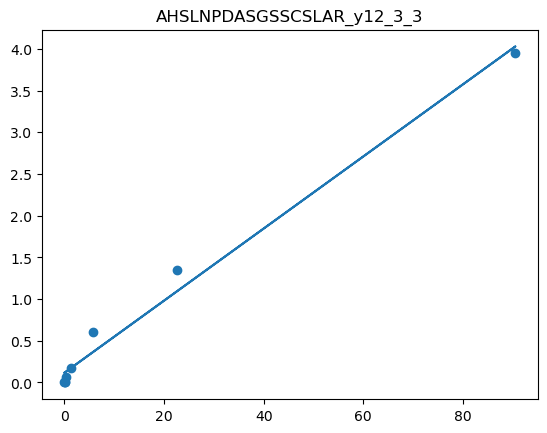

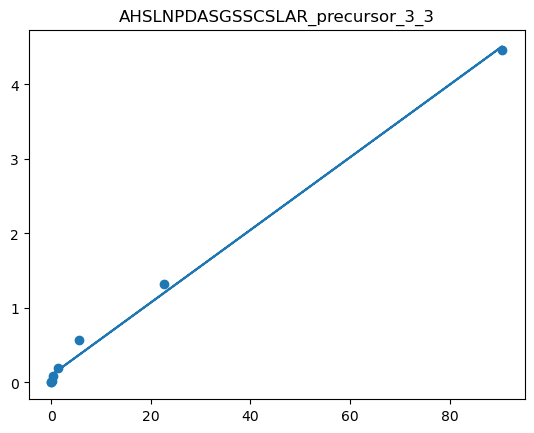

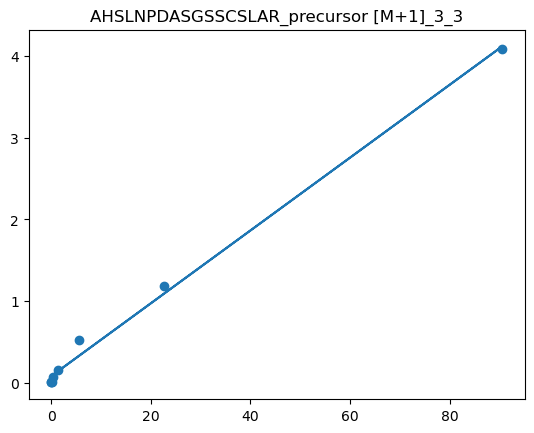

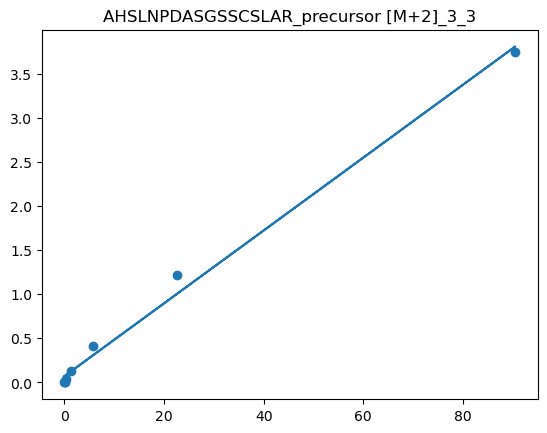

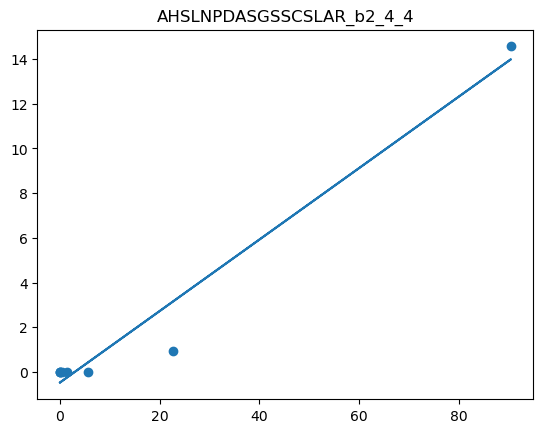

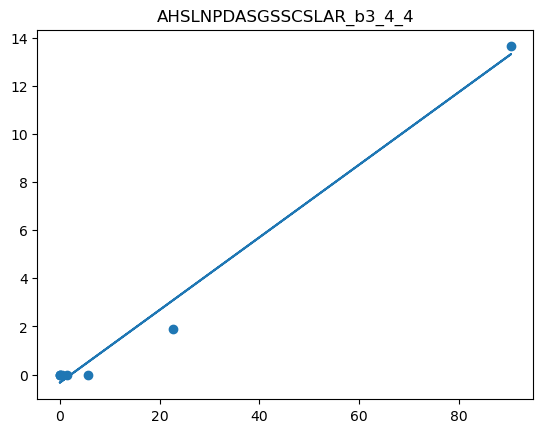

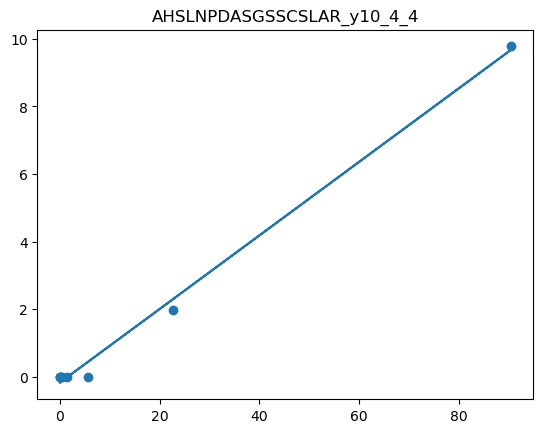

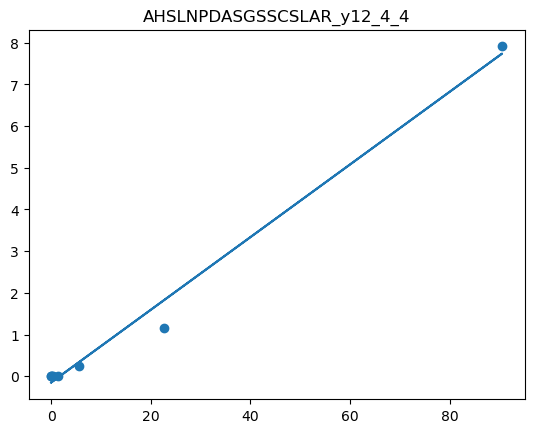

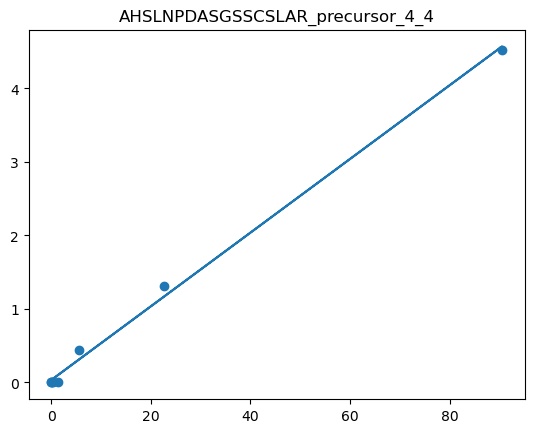

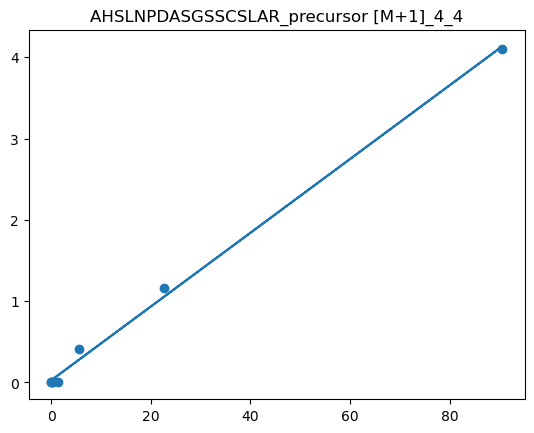

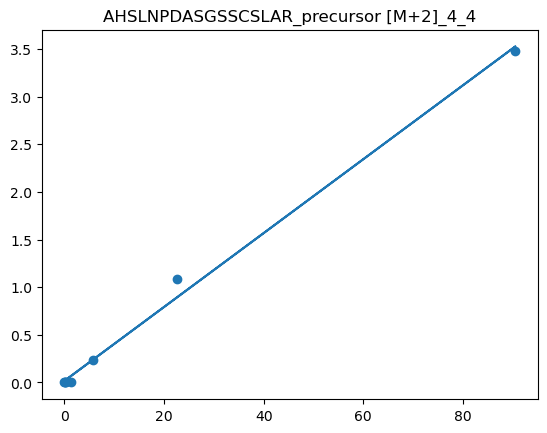

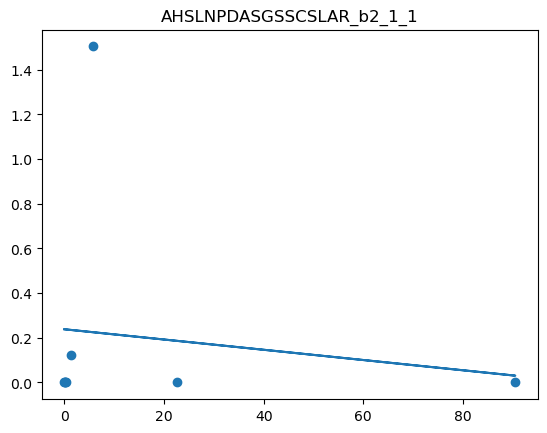

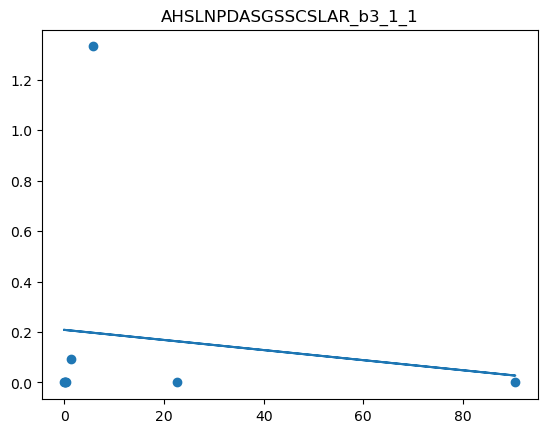

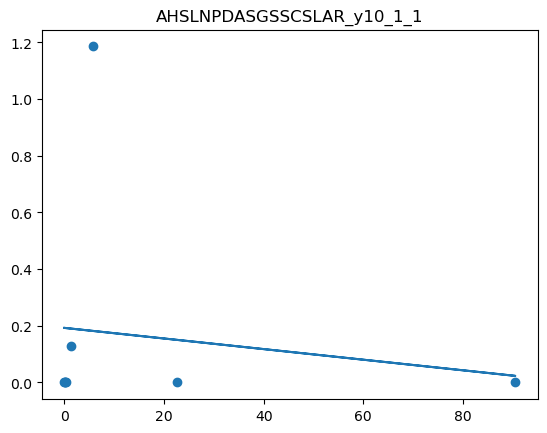

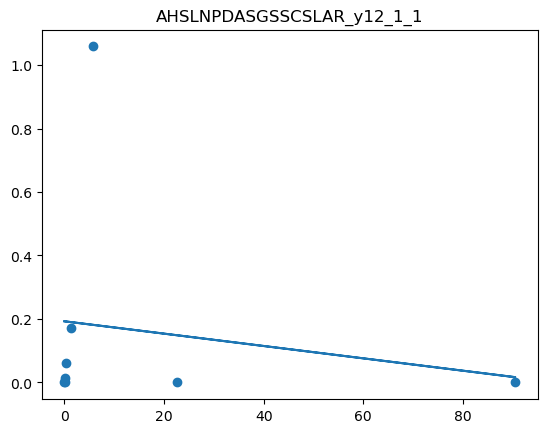

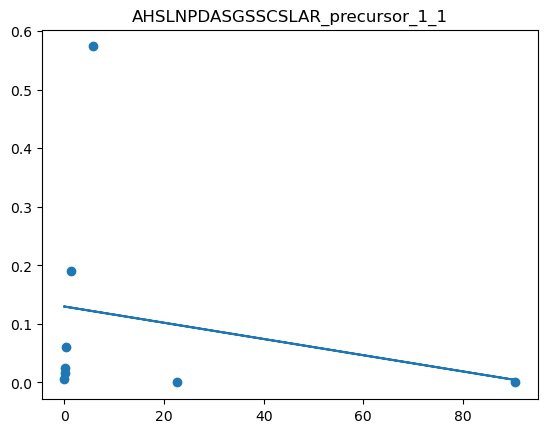

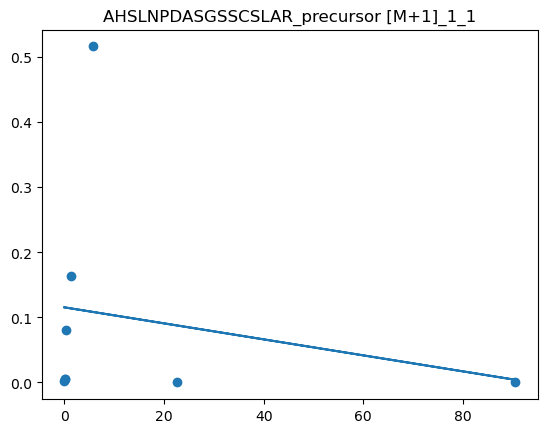

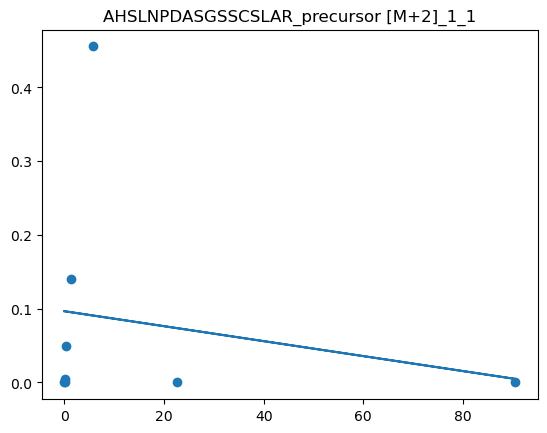

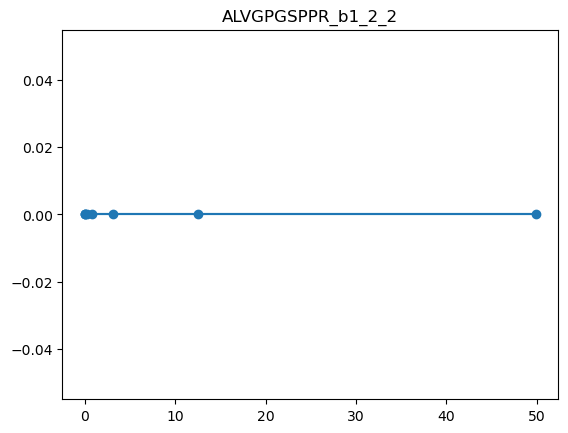

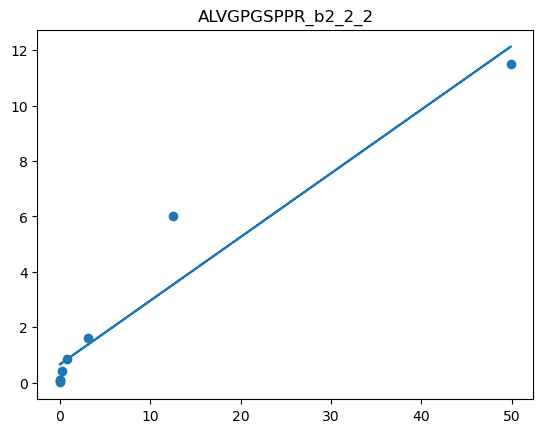

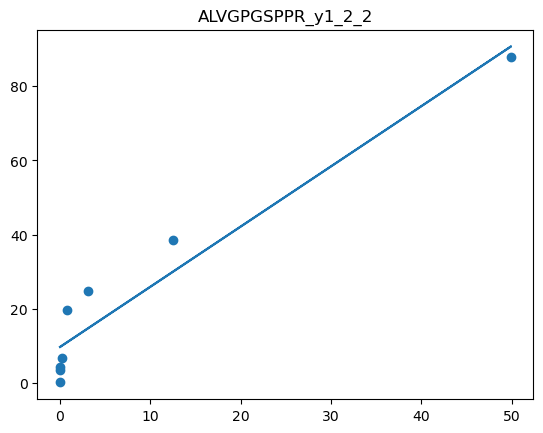

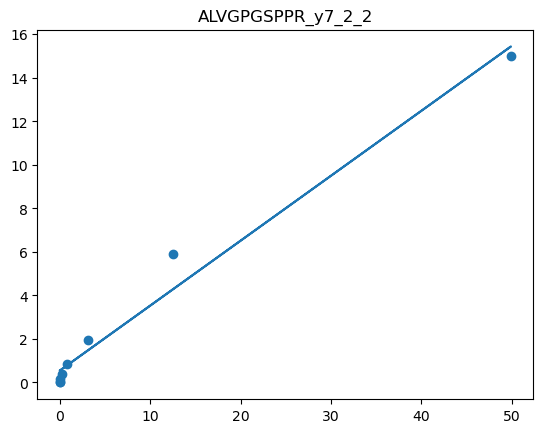

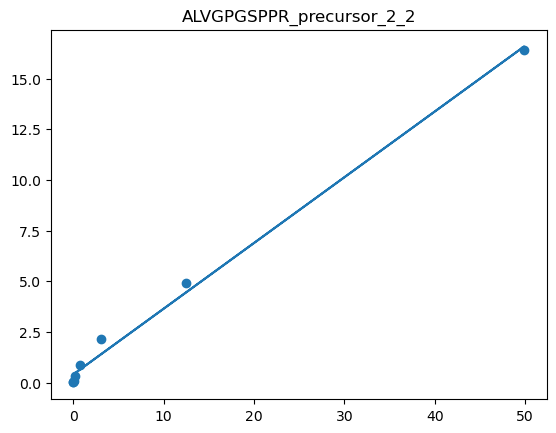

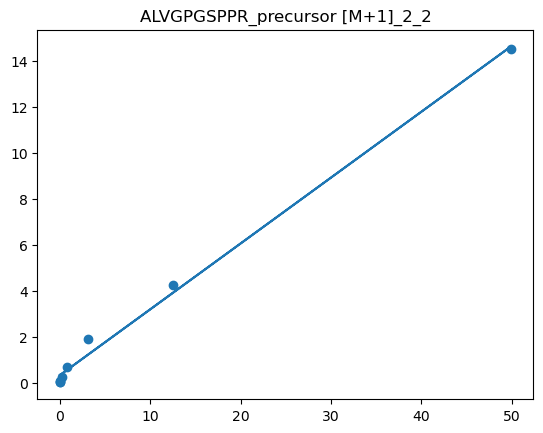

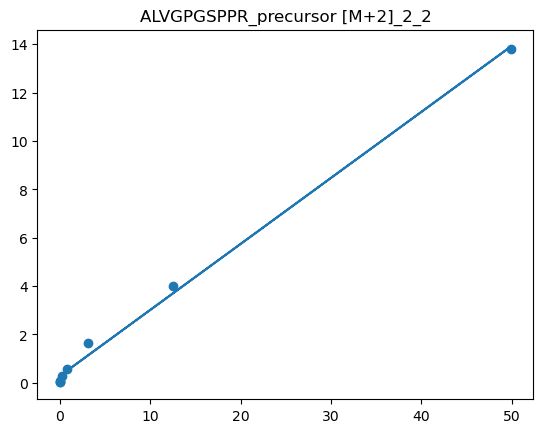

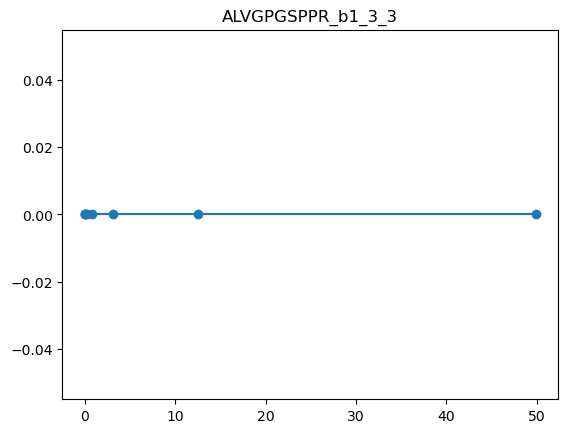

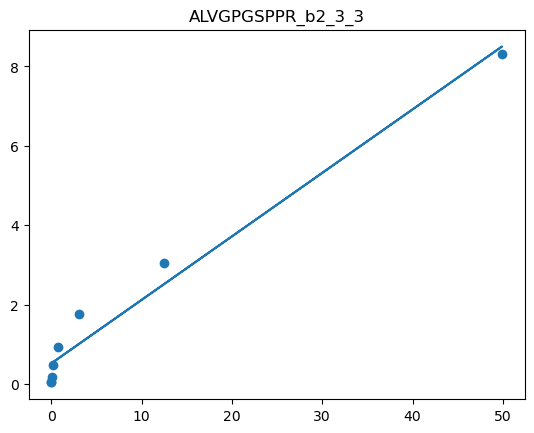

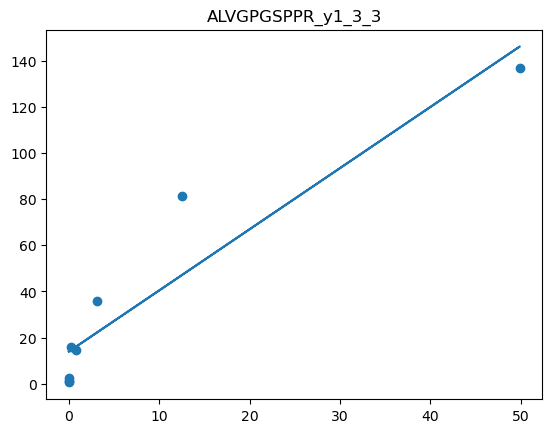

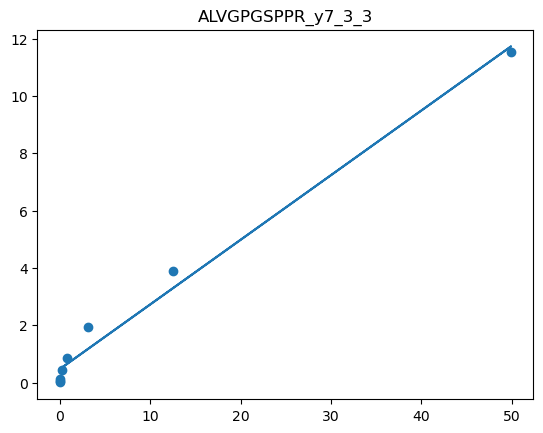

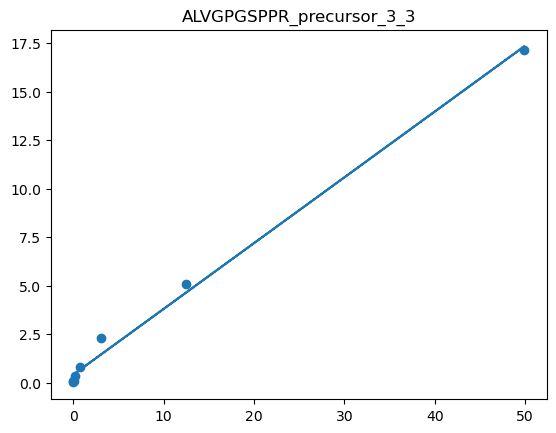

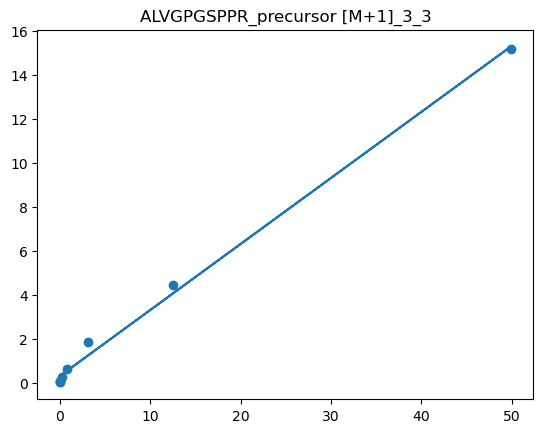

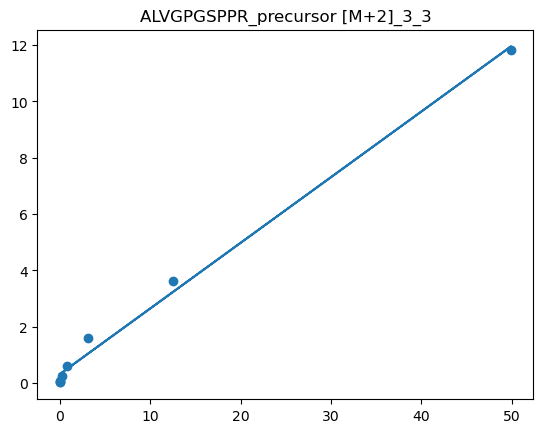

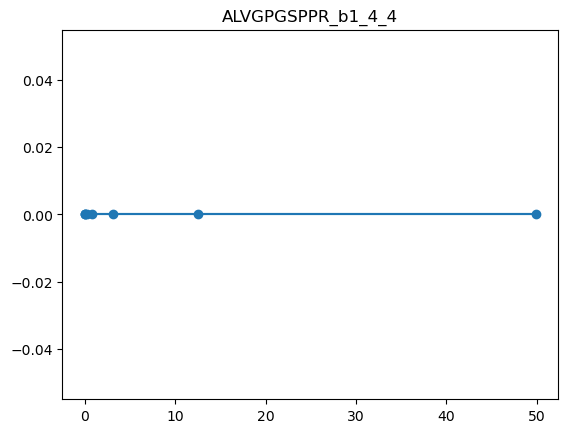

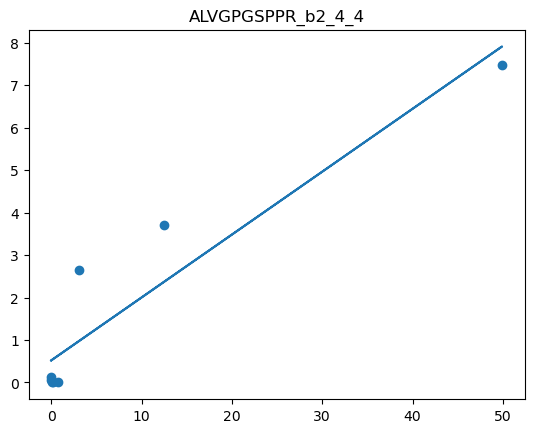

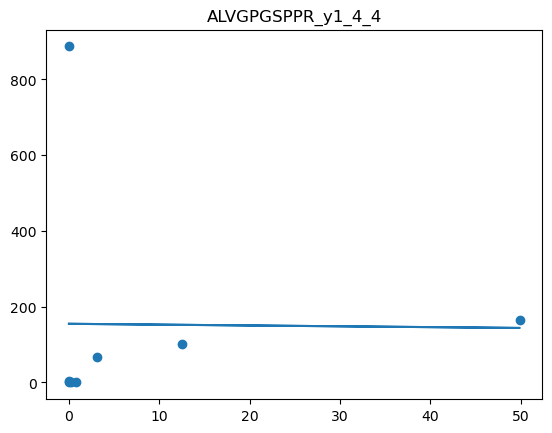

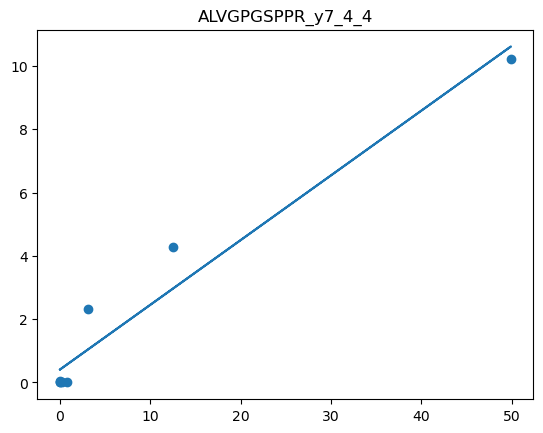

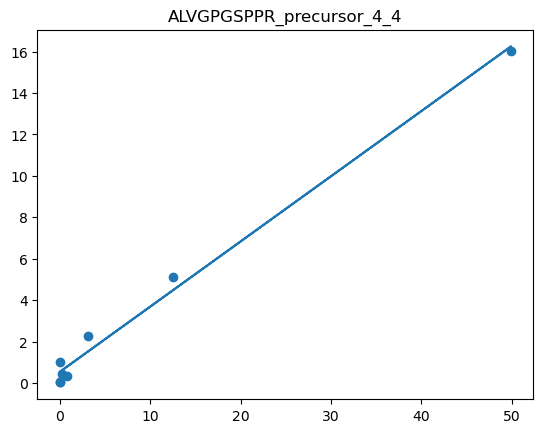

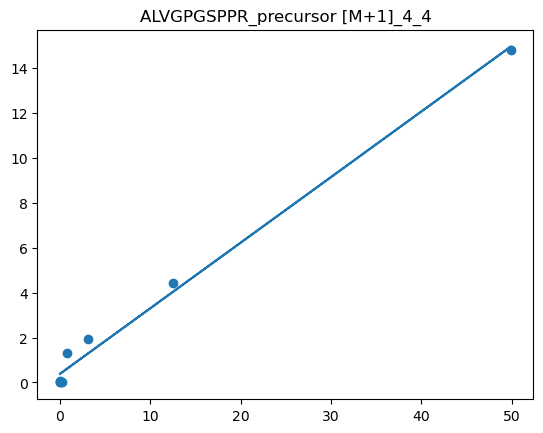

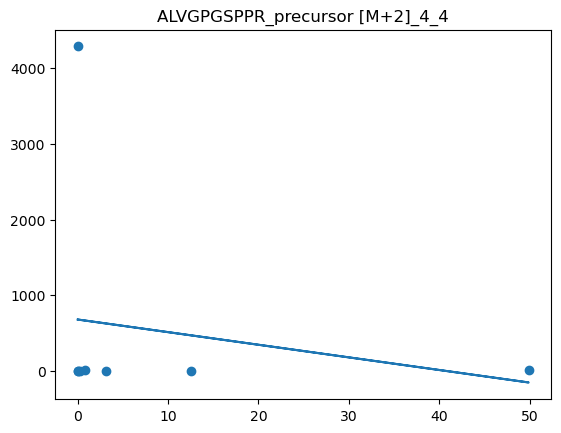

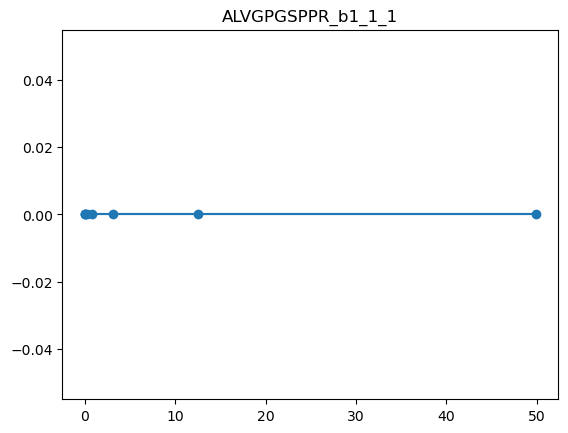

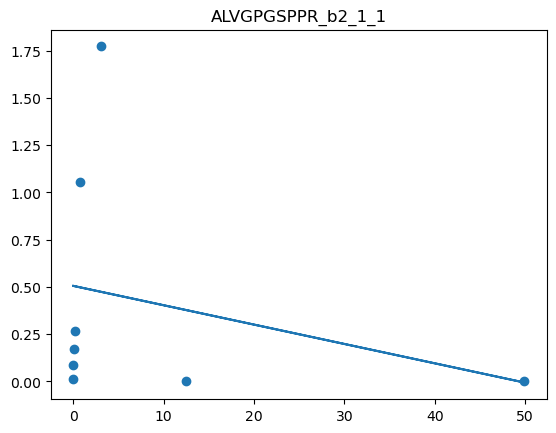

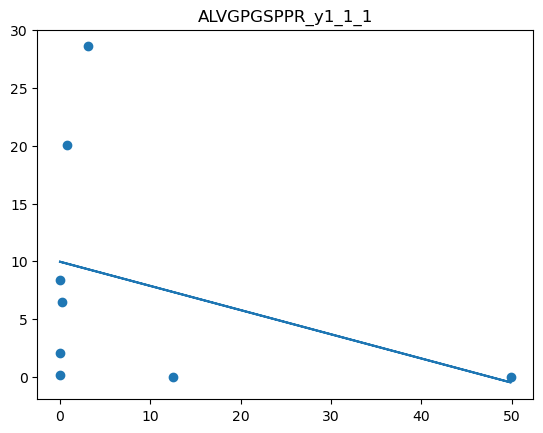

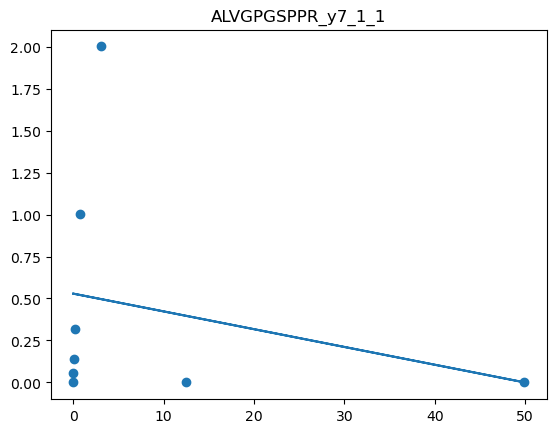

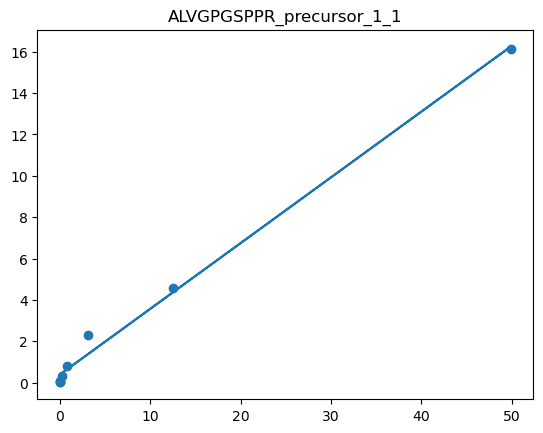

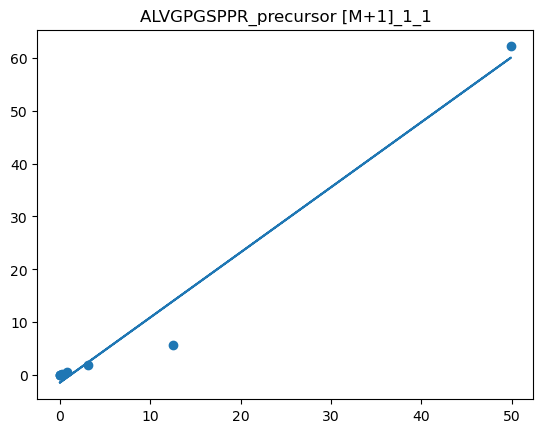

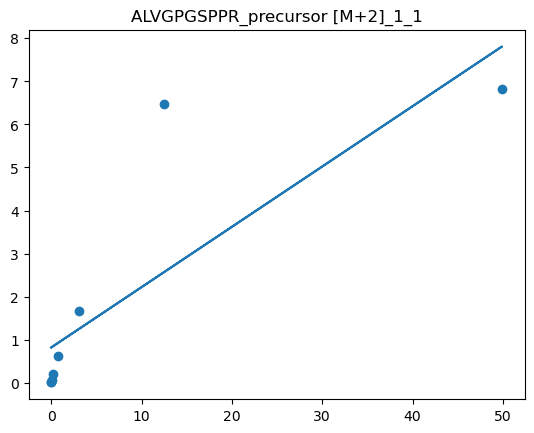

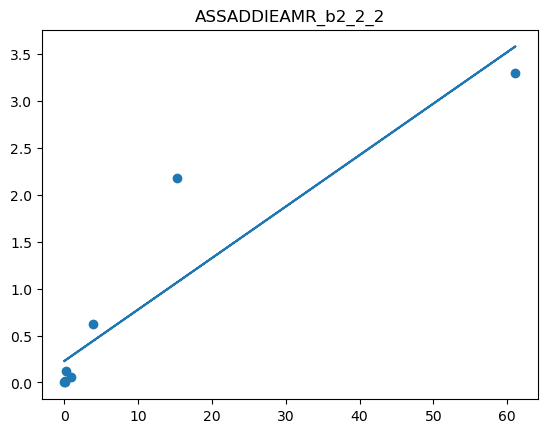

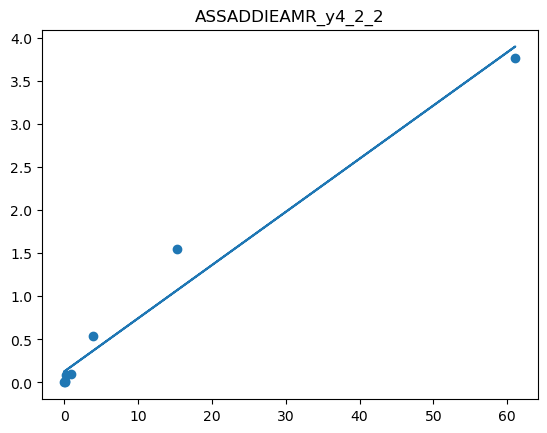

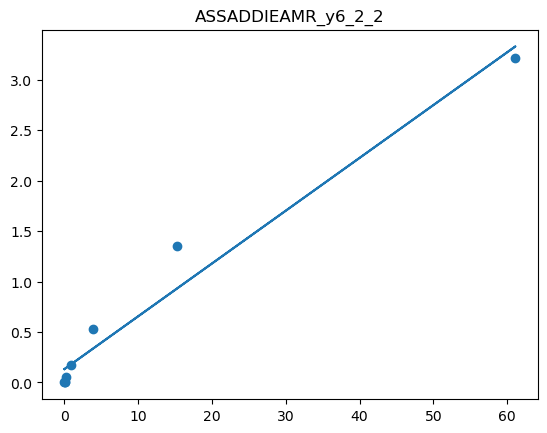

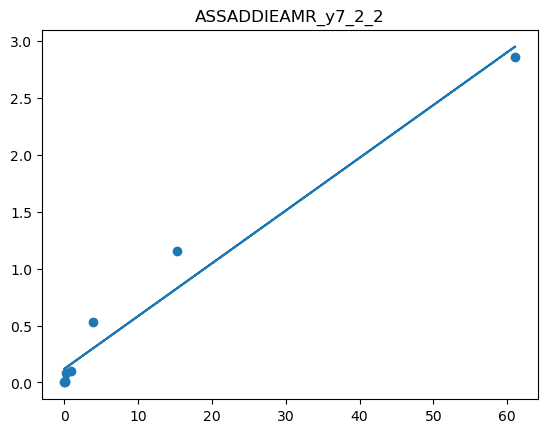

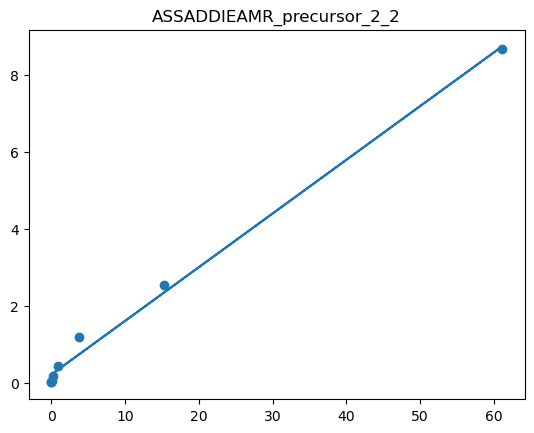

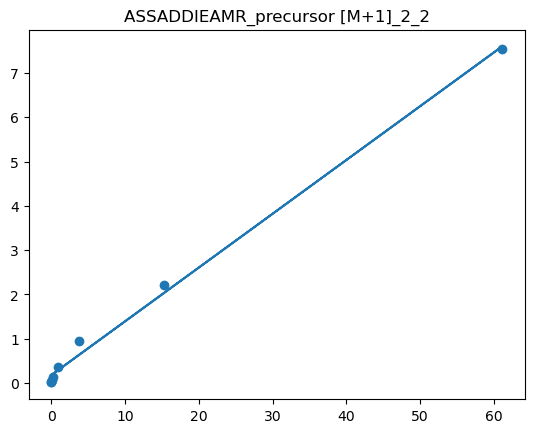

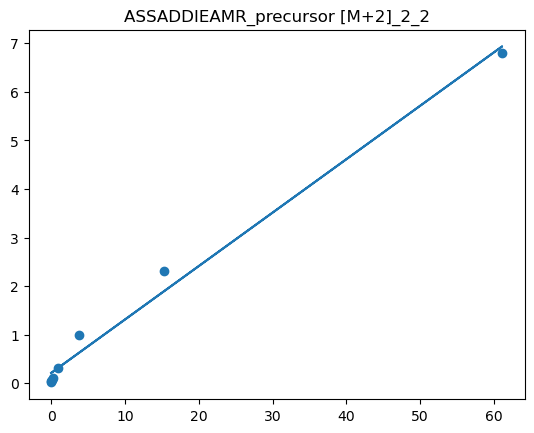

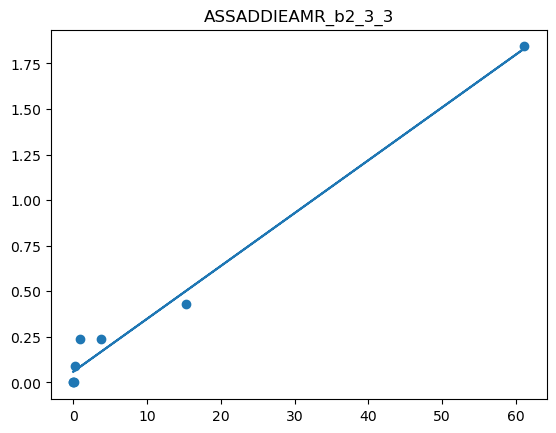

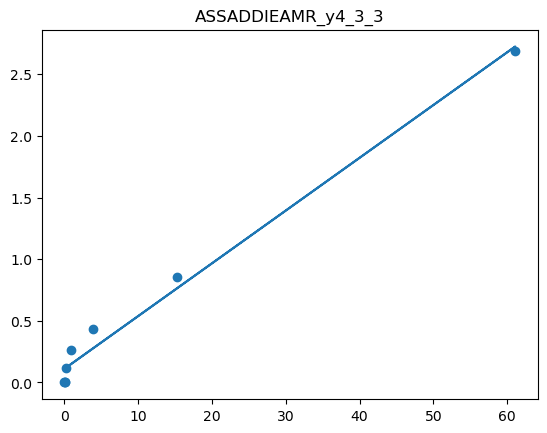

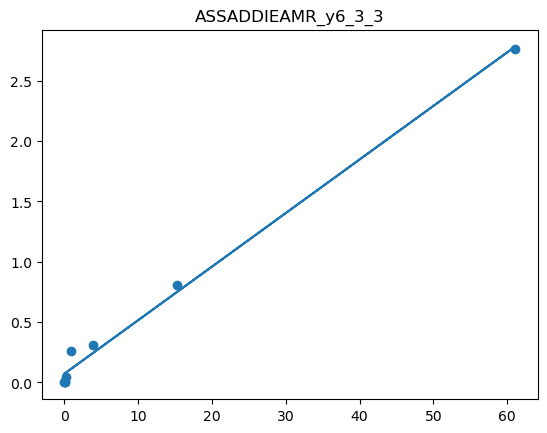

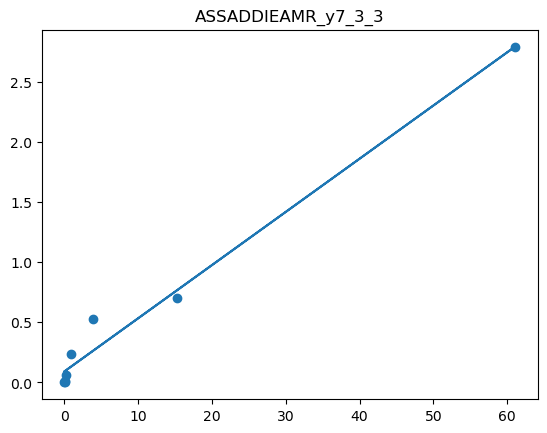

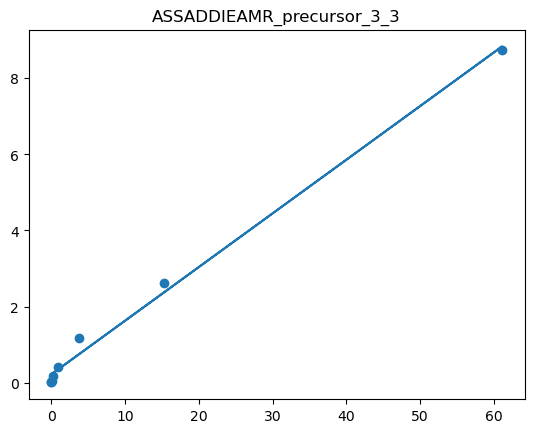

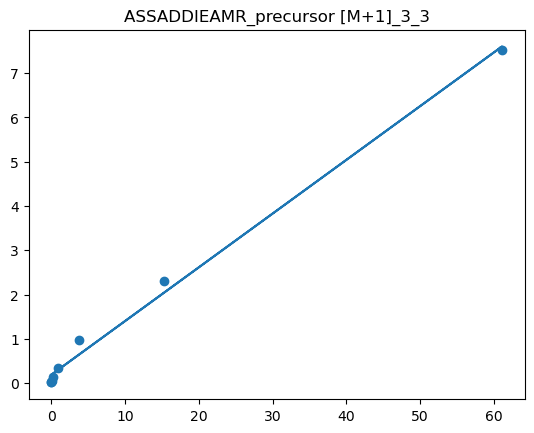

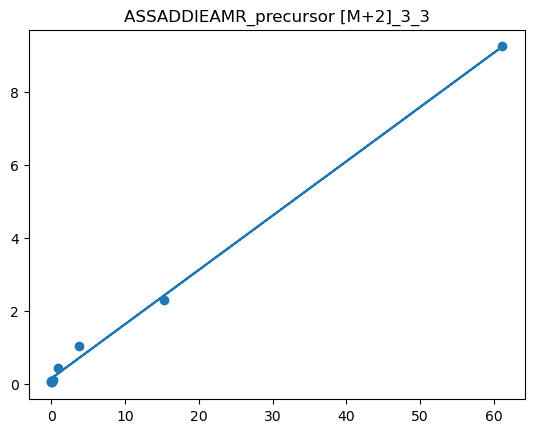

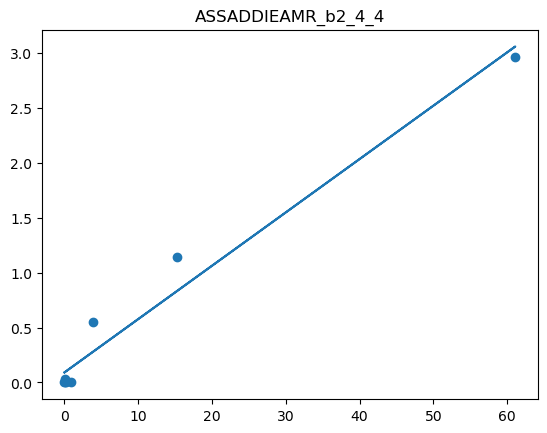

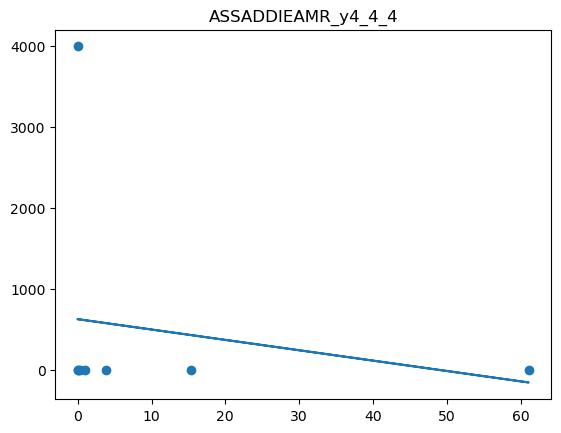

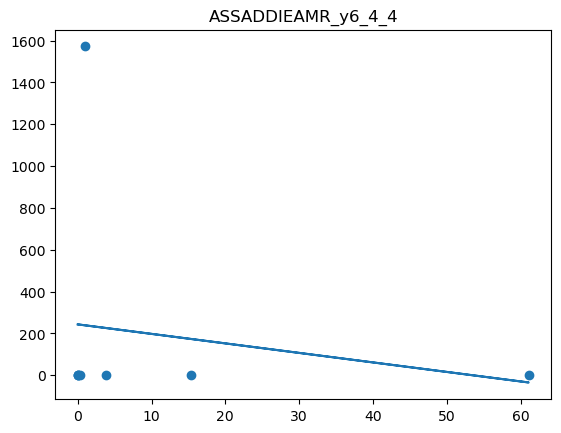

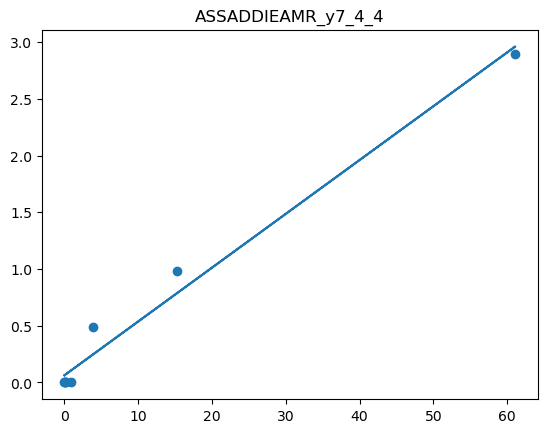

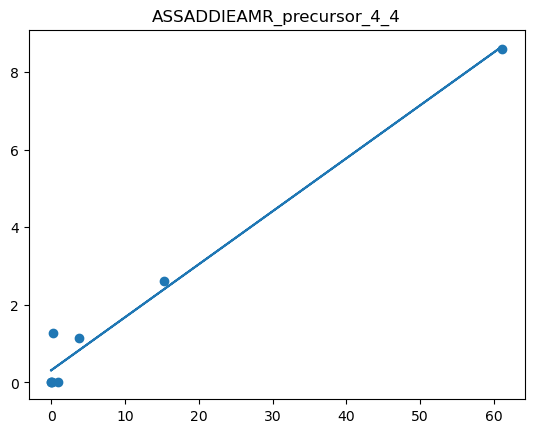

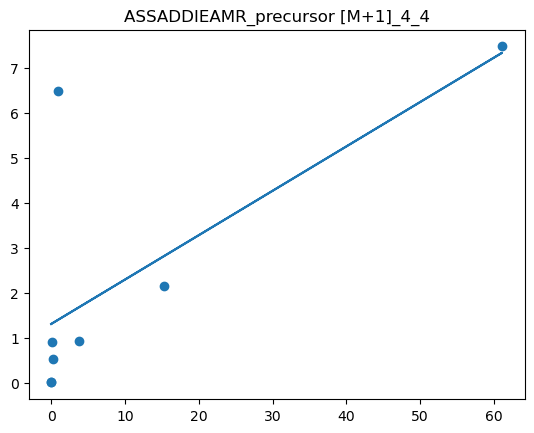

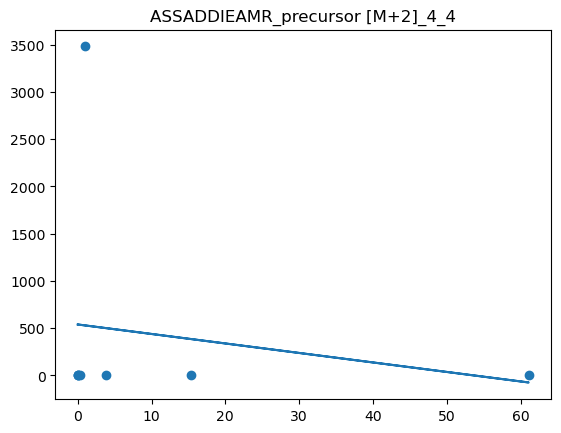

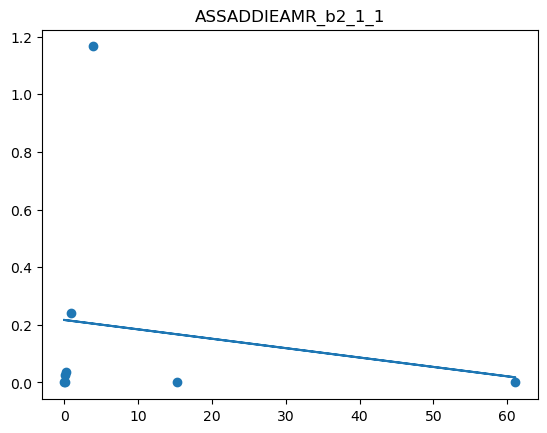

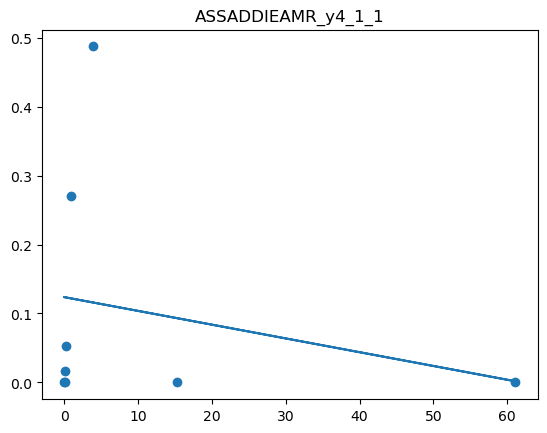

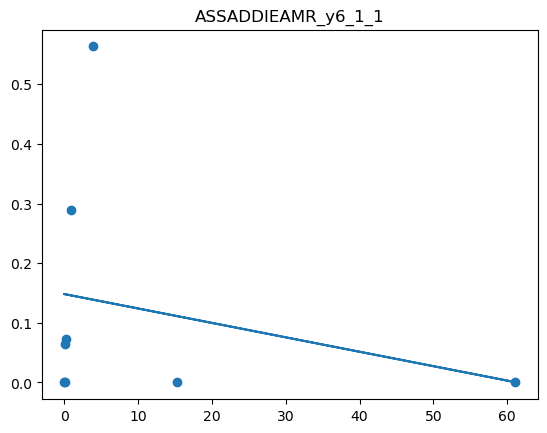

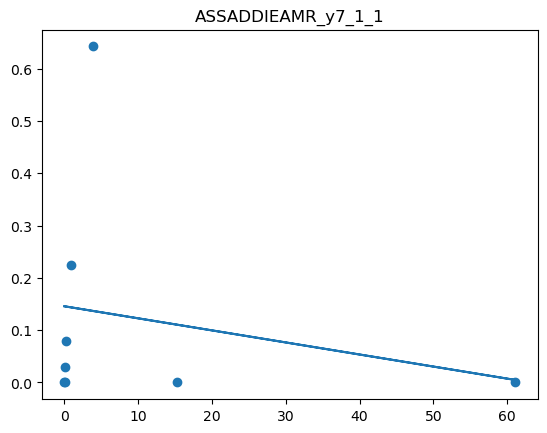

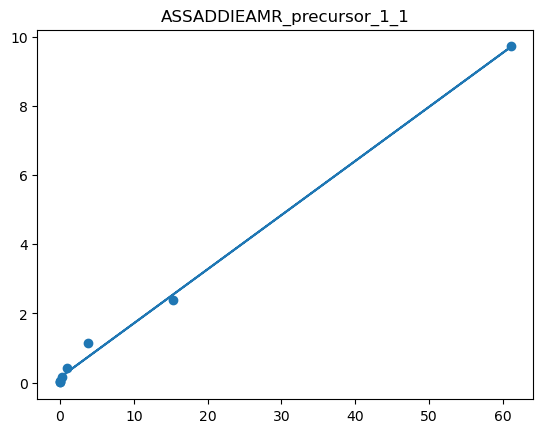

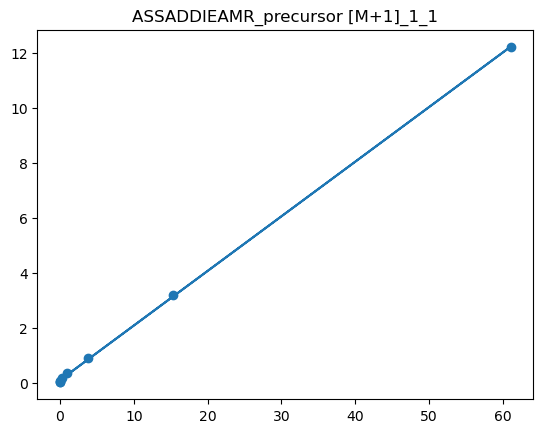

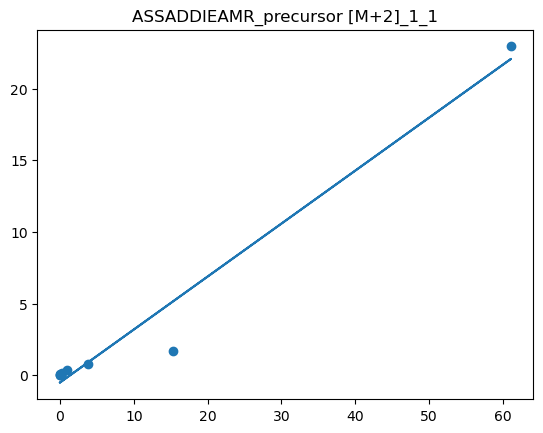

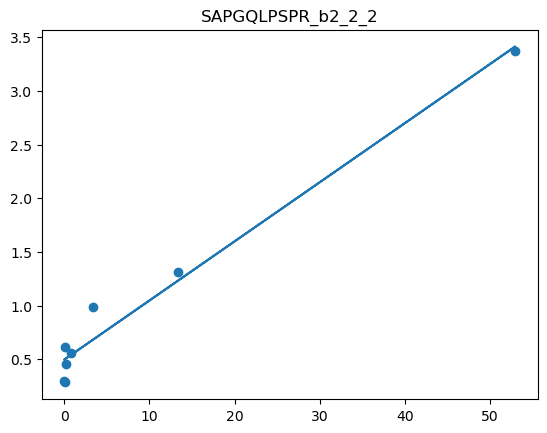

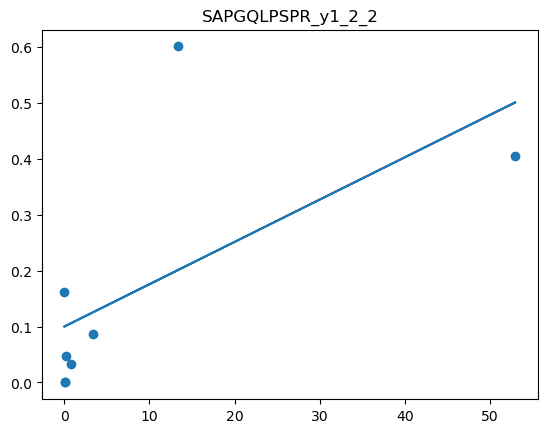

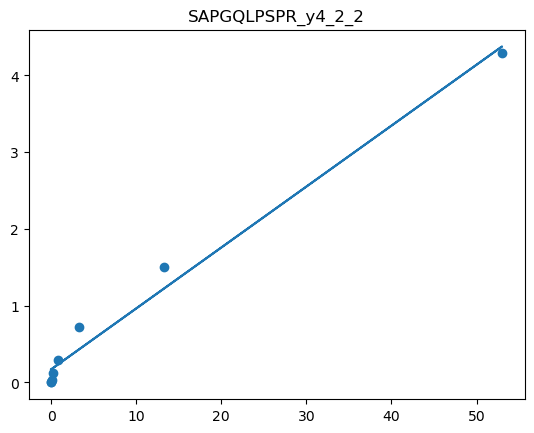

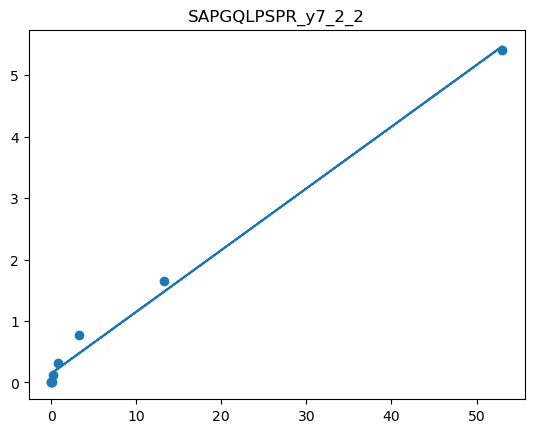

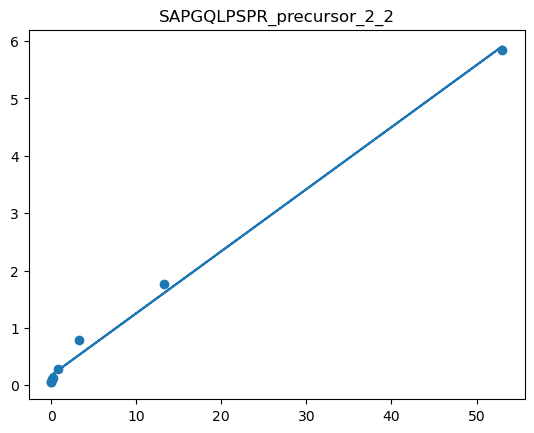

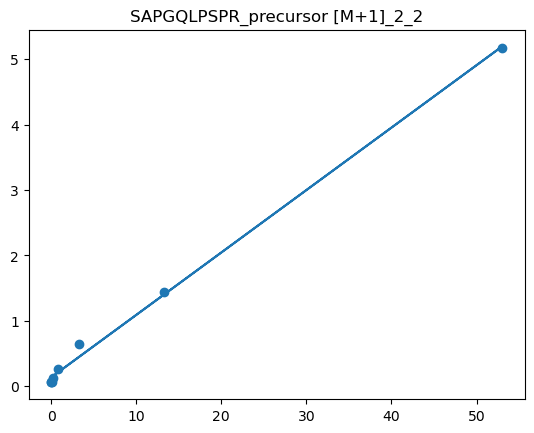

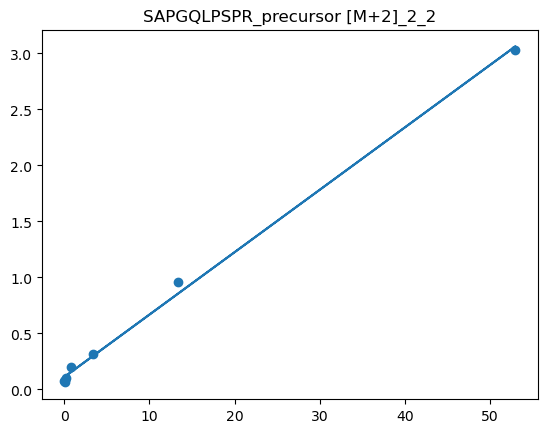

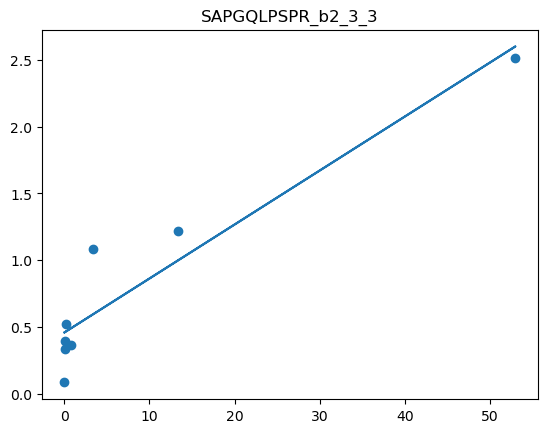

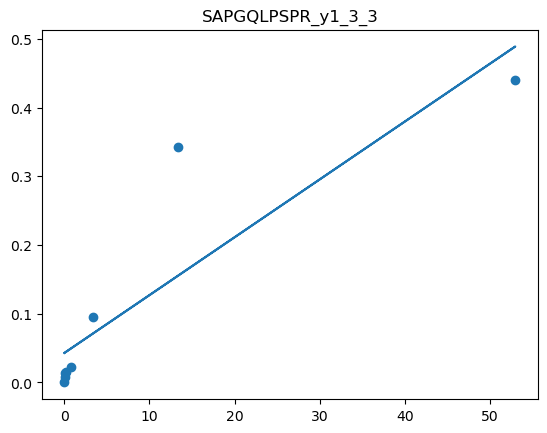

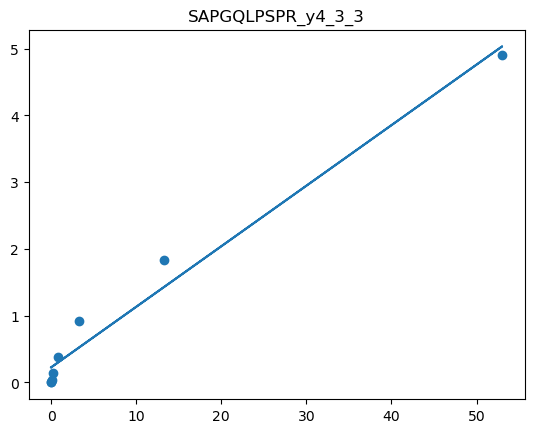

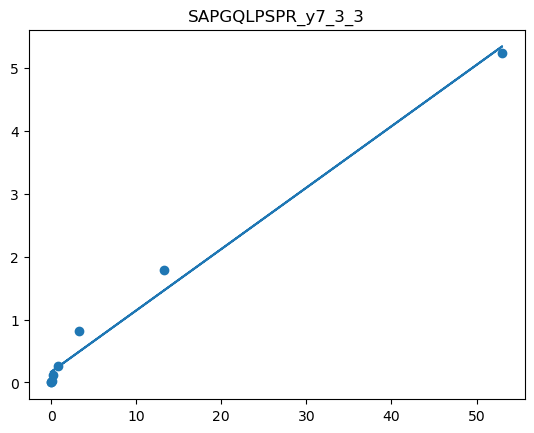

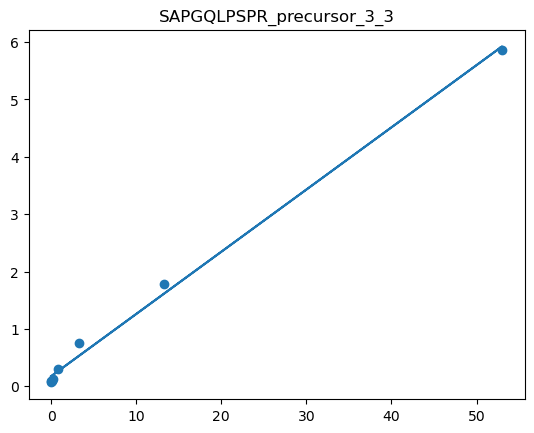

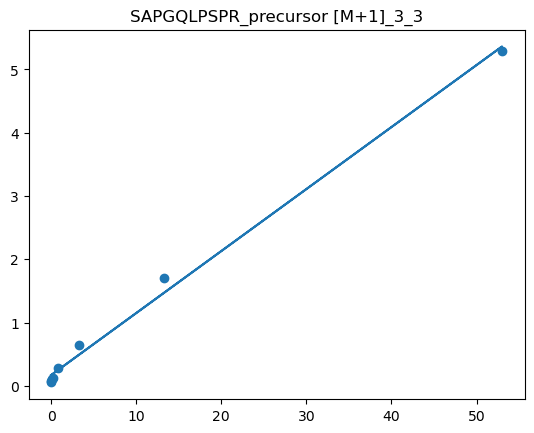

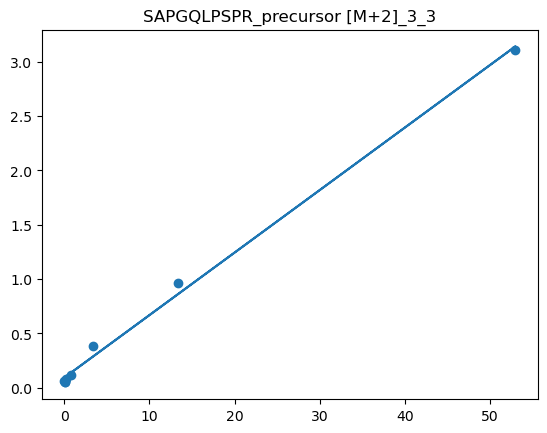

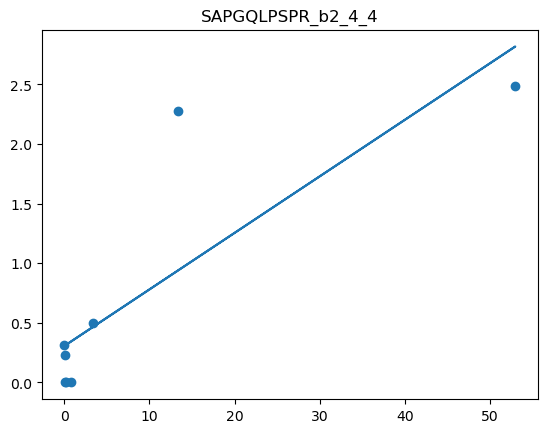

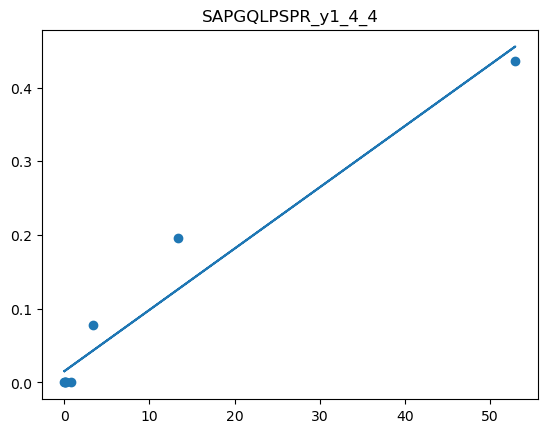

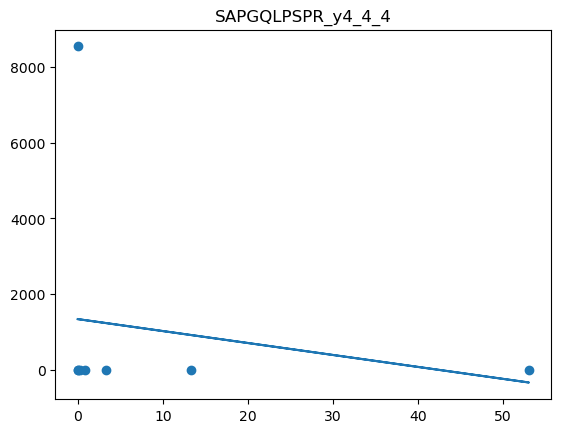

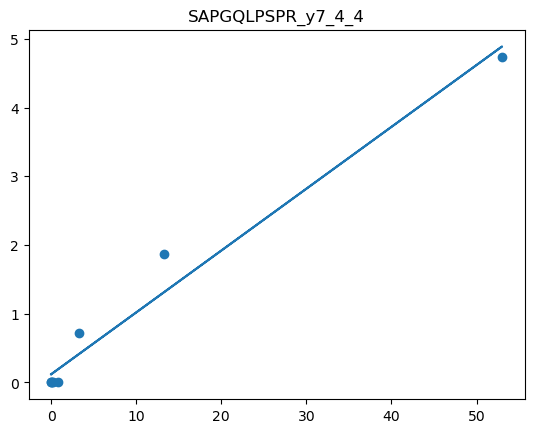

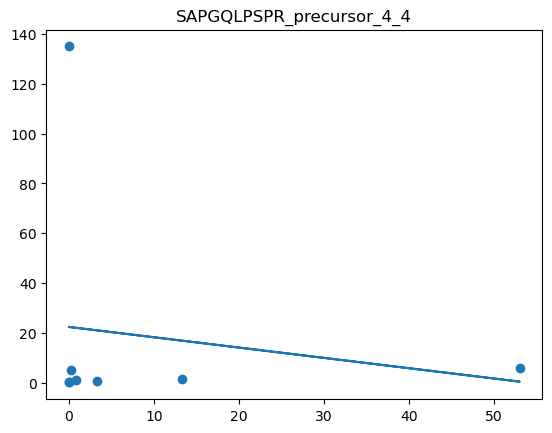

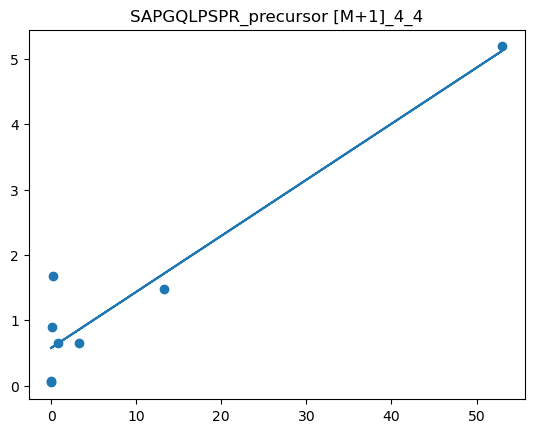

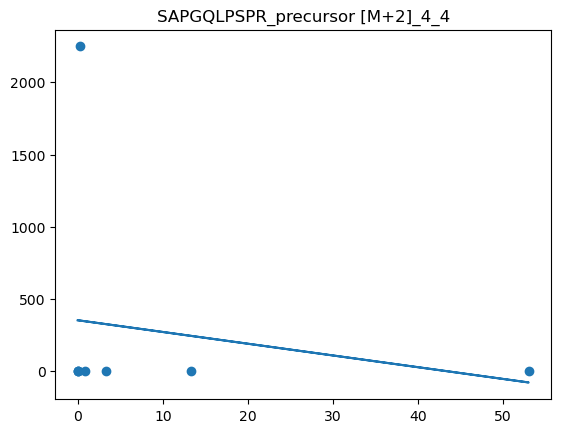

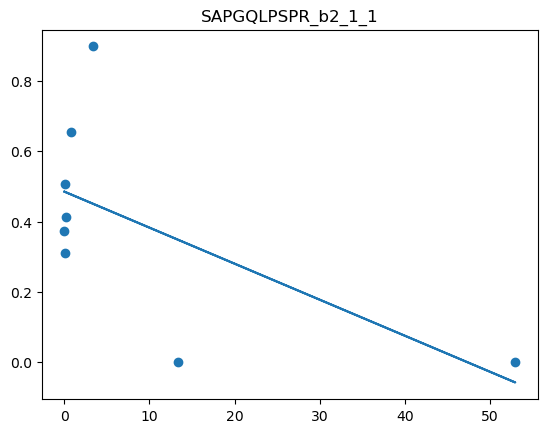

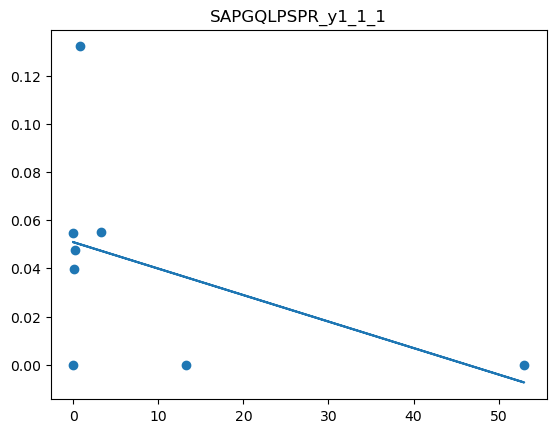

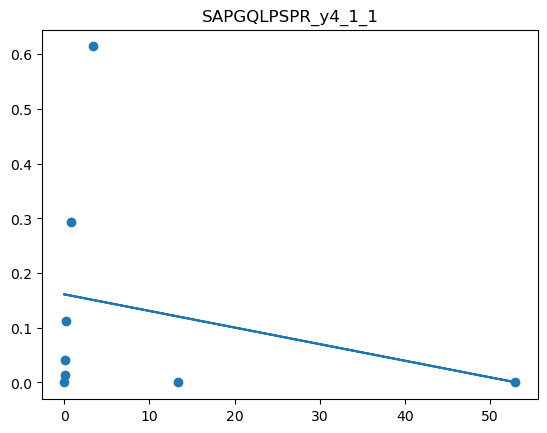

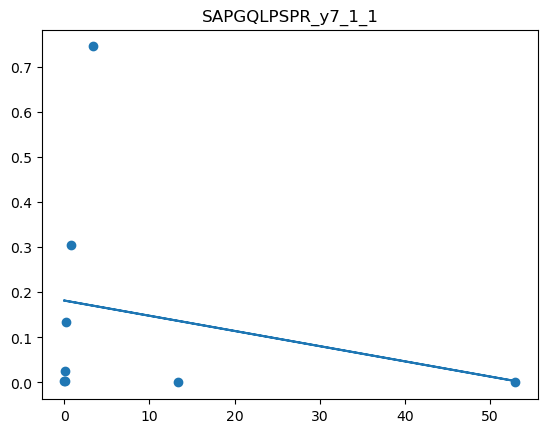

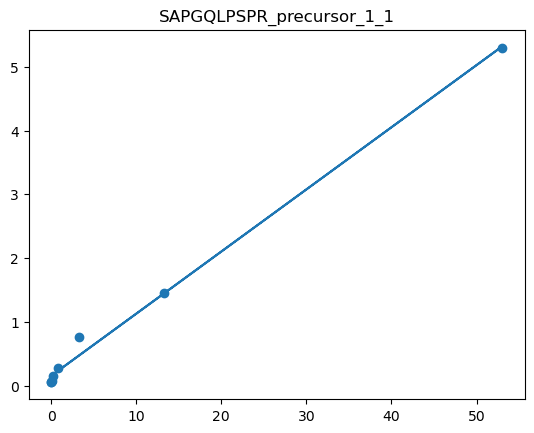

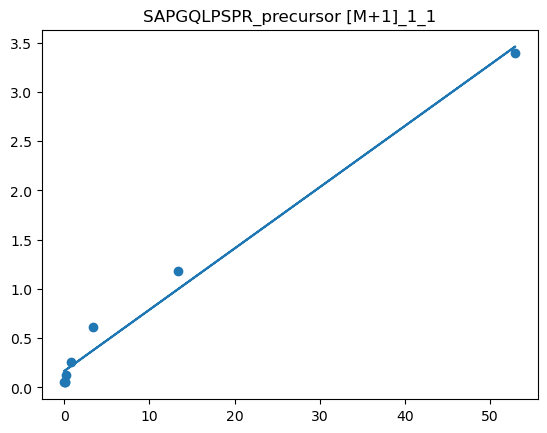

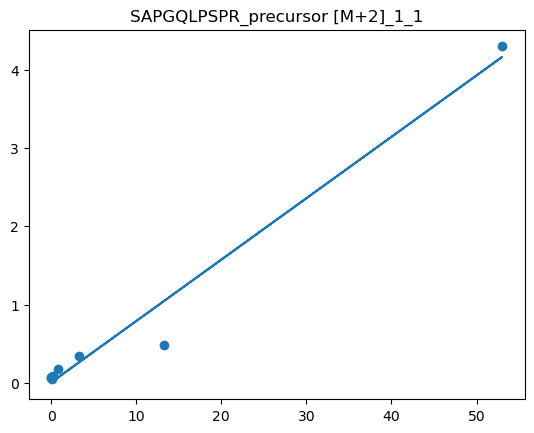

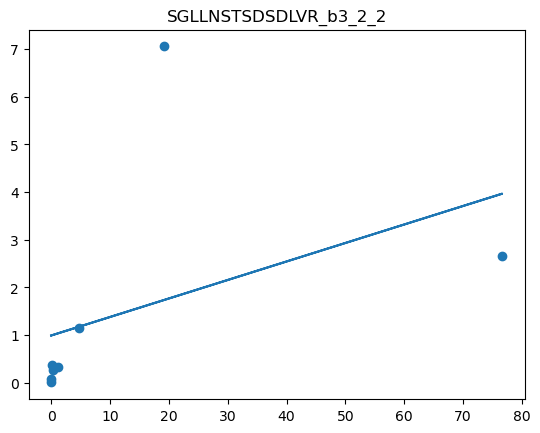

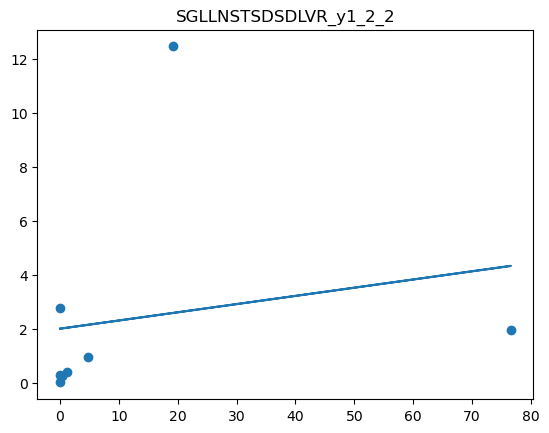

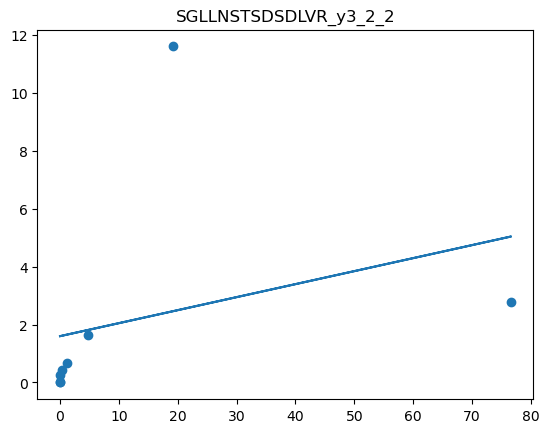

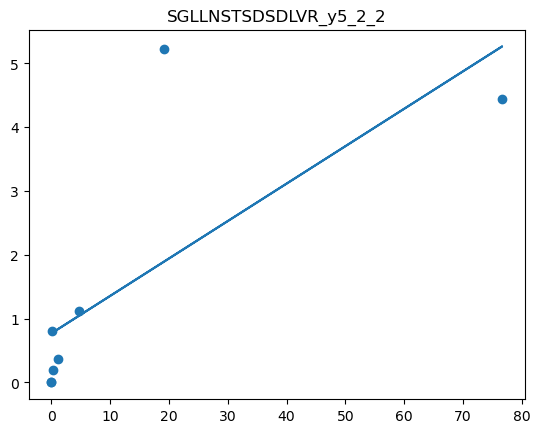

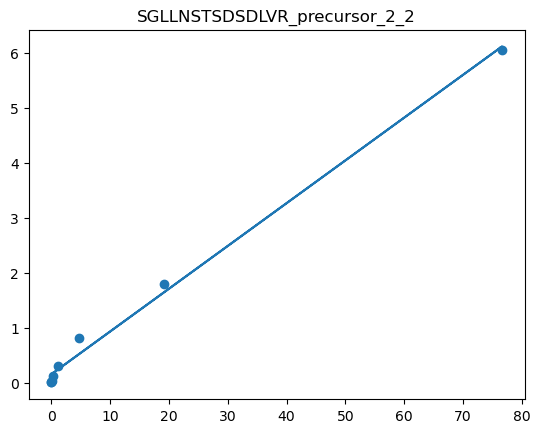

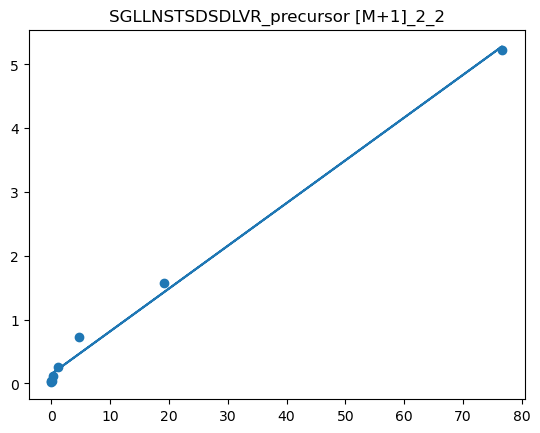

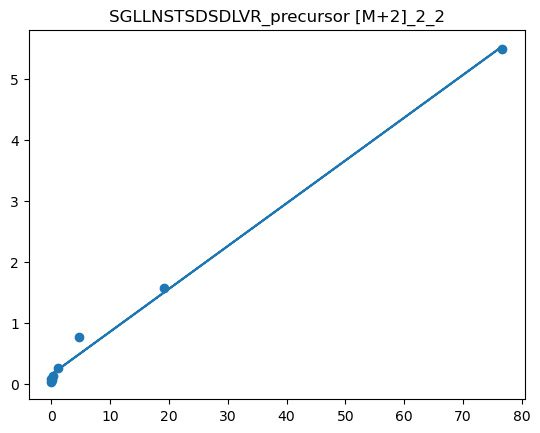

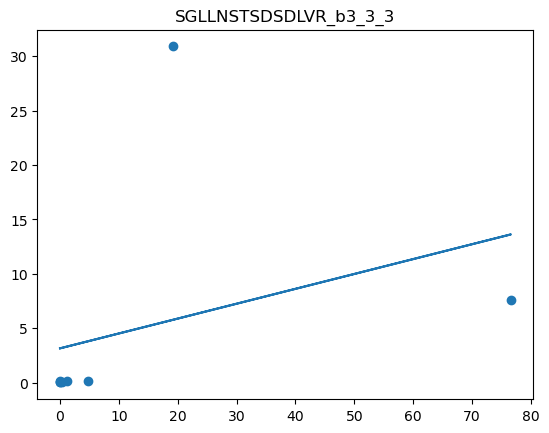

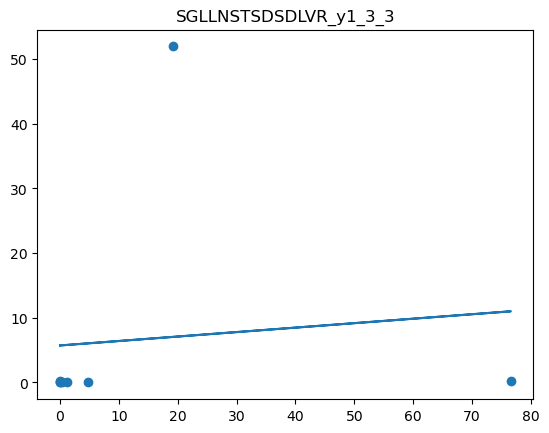

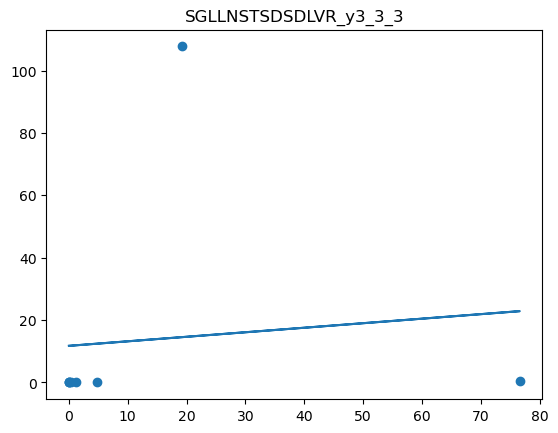

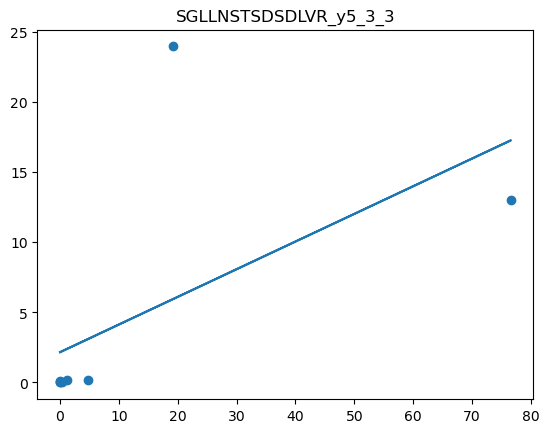

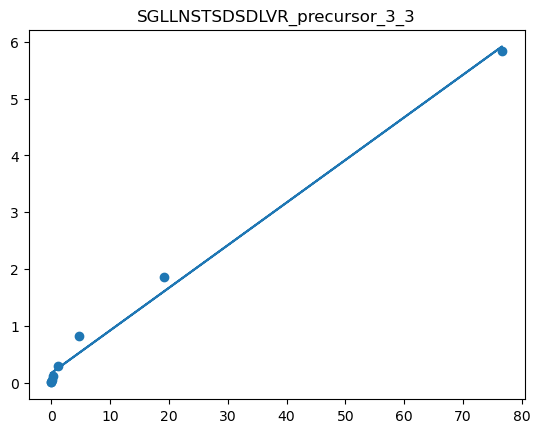

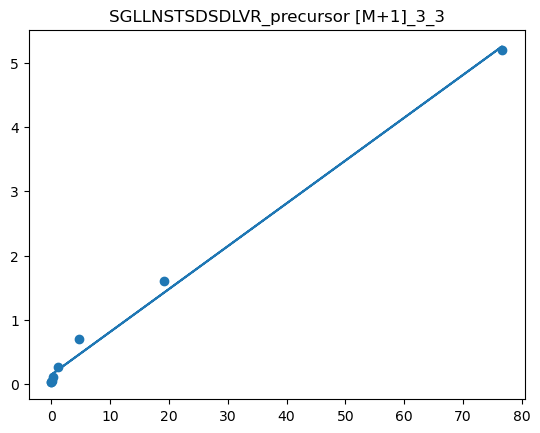

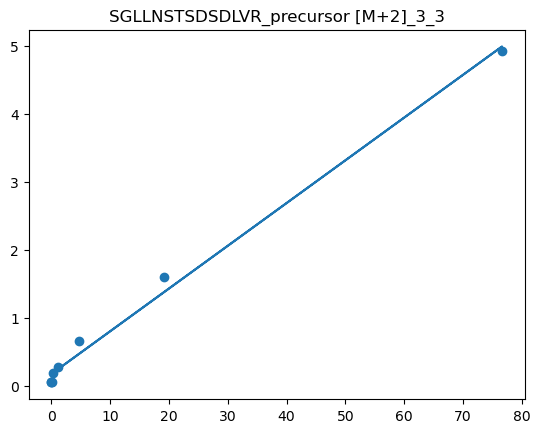

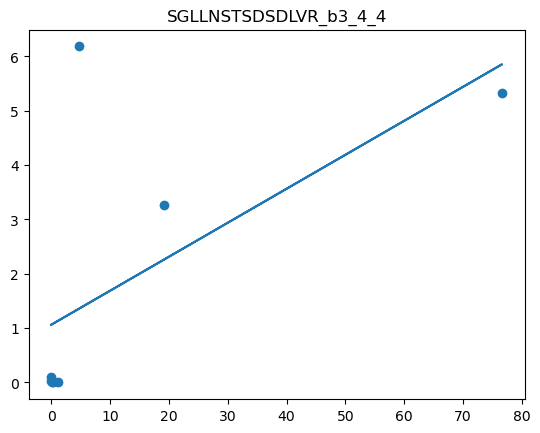

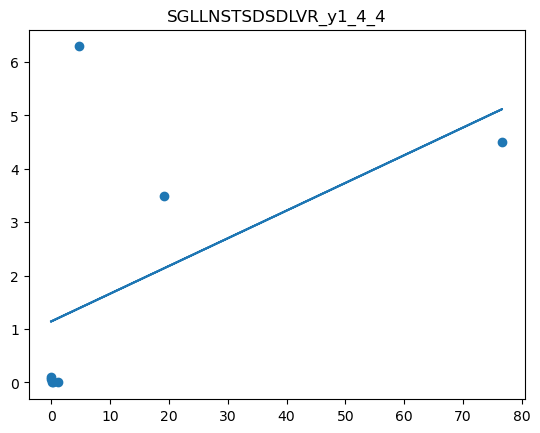

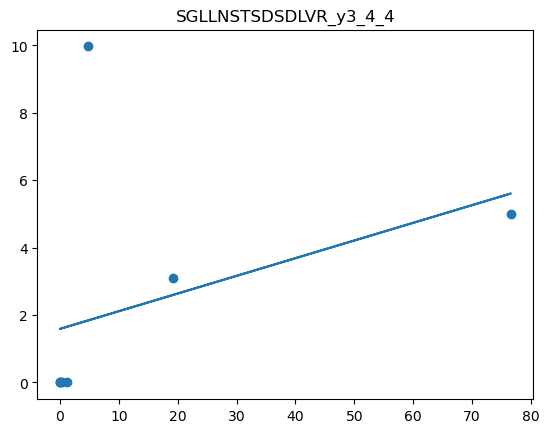

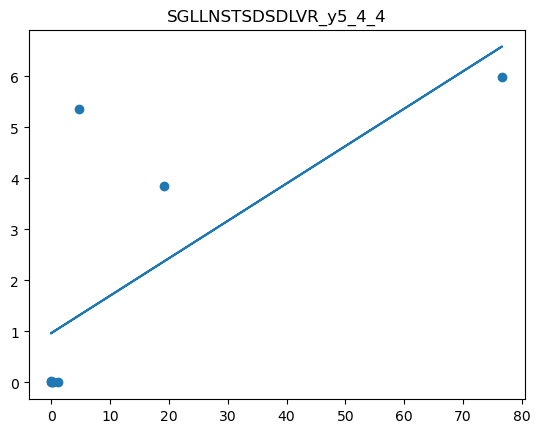

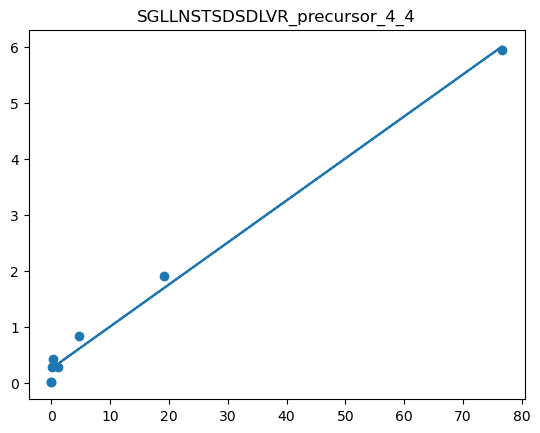

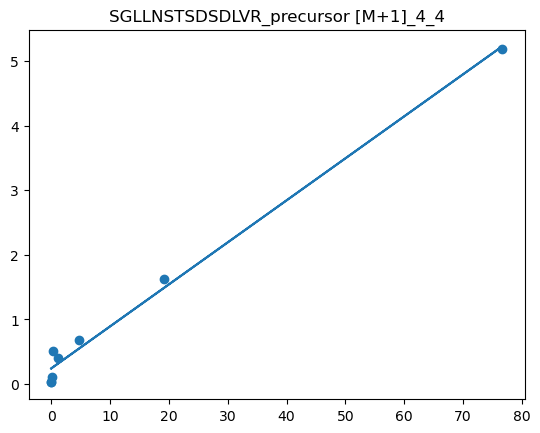

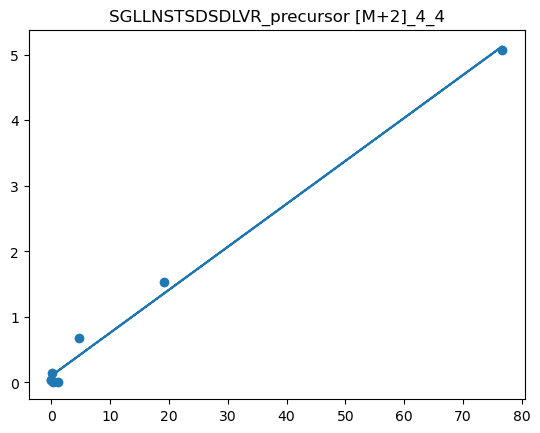

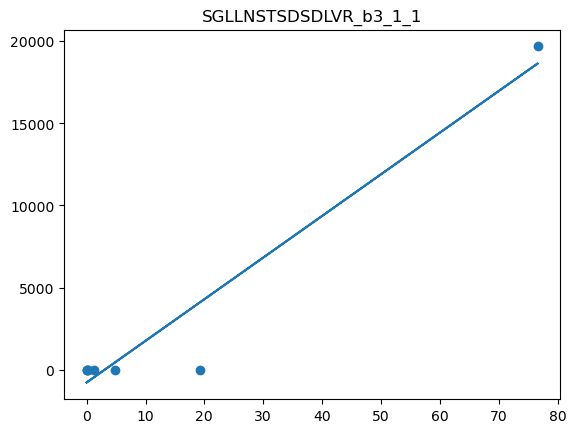

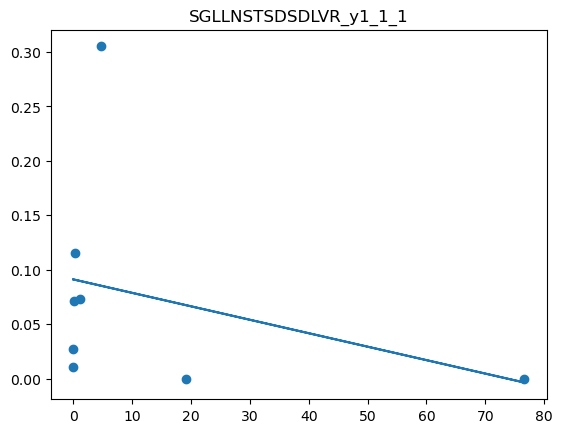

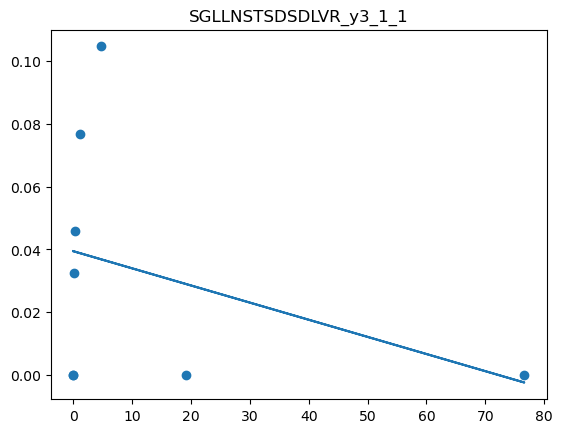

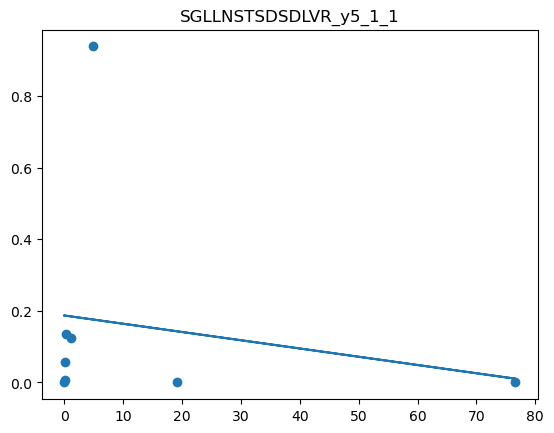

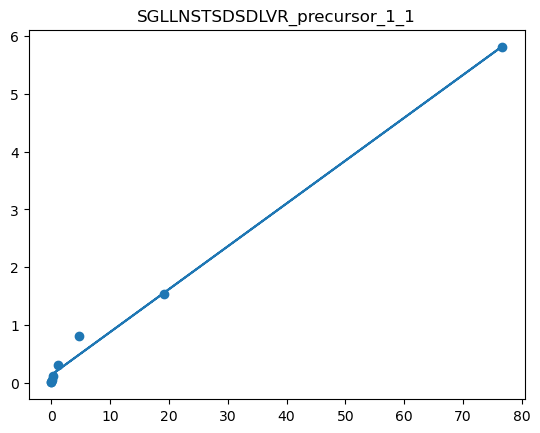

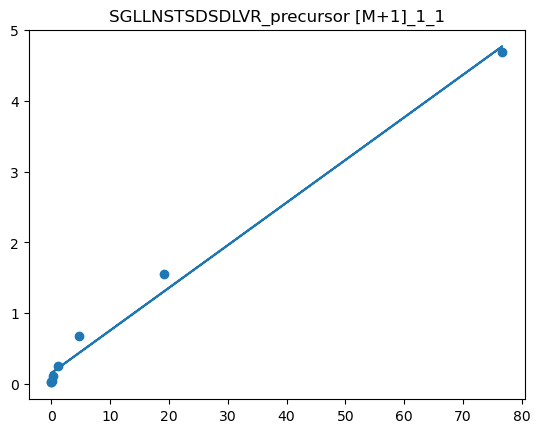

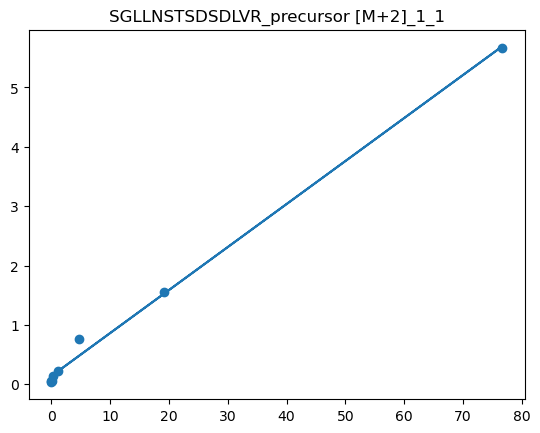

In [29]:
result_data_folder = pathlib.Path("../../reports/ms_work/peggy_2/plots_1_over_x_3")
for cat in plot_cats:
    fig, ax = plt.subplots()
    ax = get_plot(plot_df, cat, ax)
    fig = plt.gcf()
    fig.savefig(fname=result_data_folder.joinpath(cat))

### Plots (by group)

C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\Aroge\anaconda3\envs\genomic\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarnin

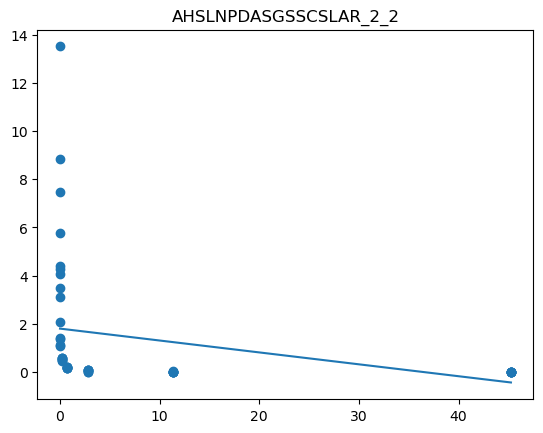

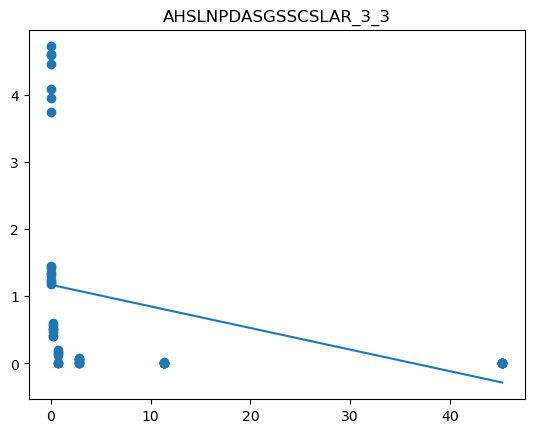

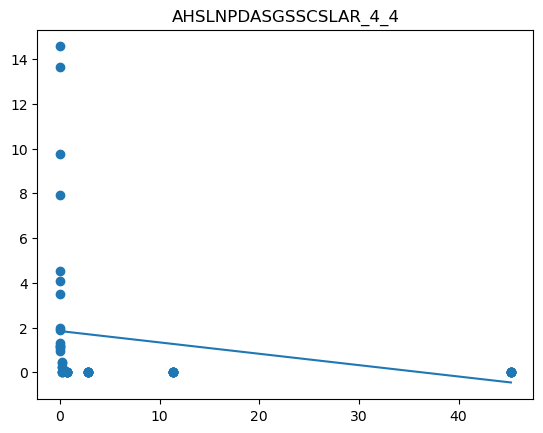

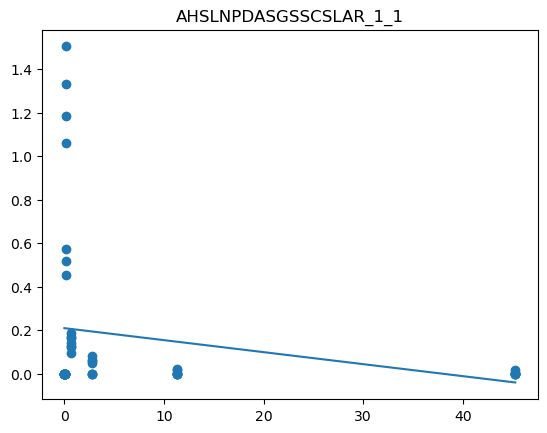

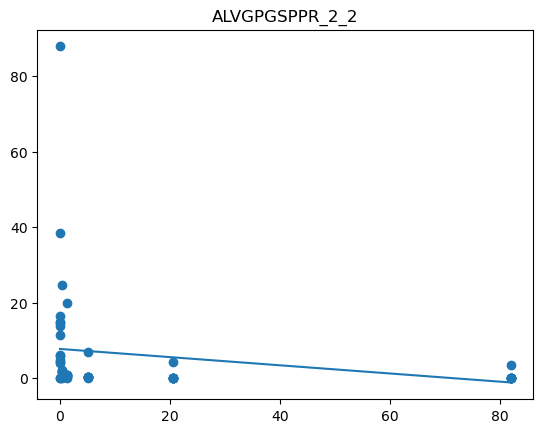

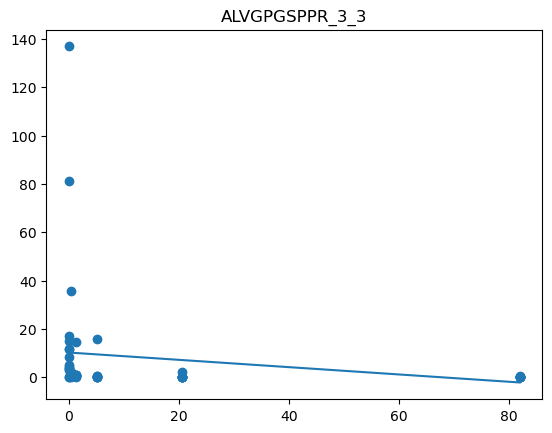

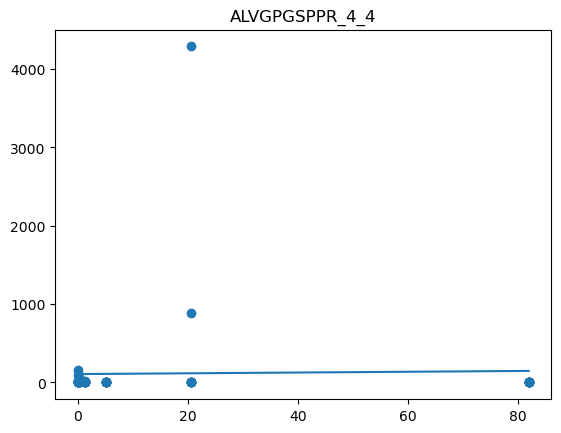

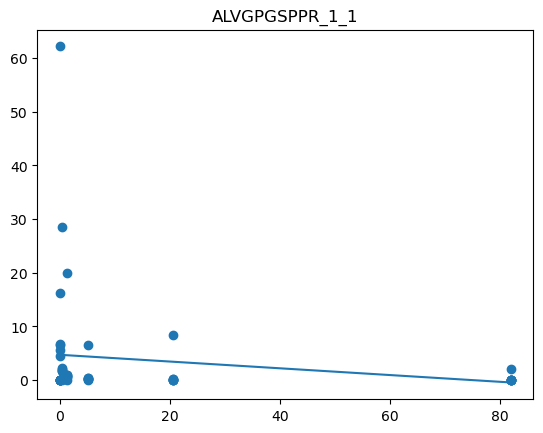

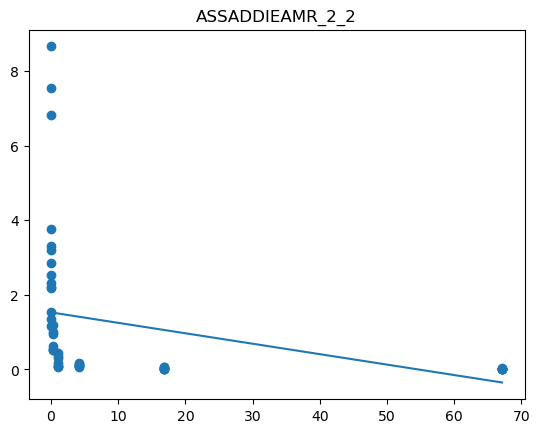

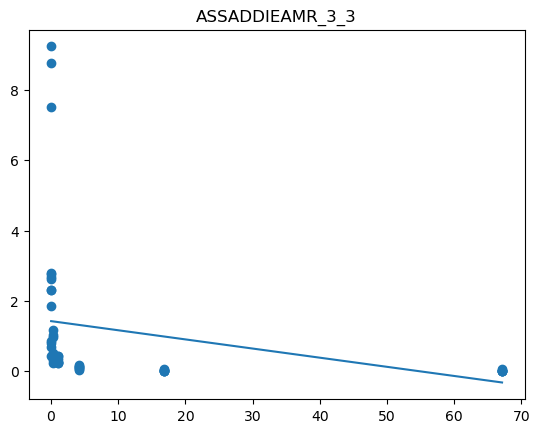

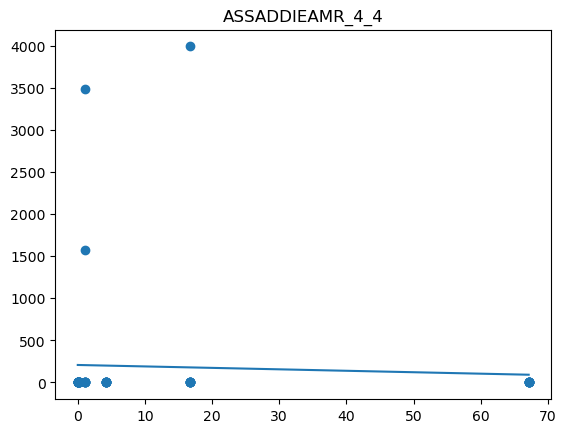

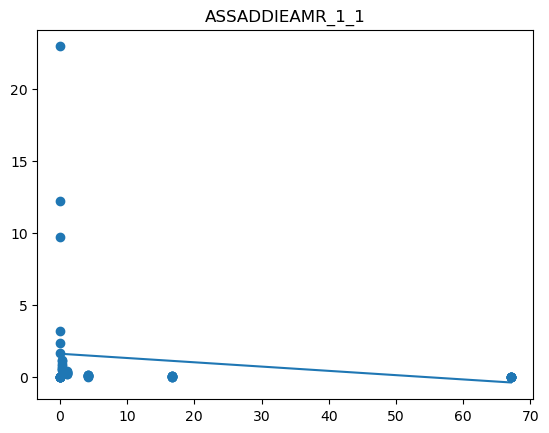

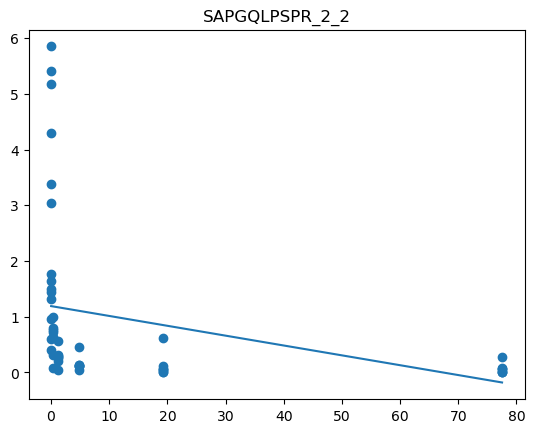

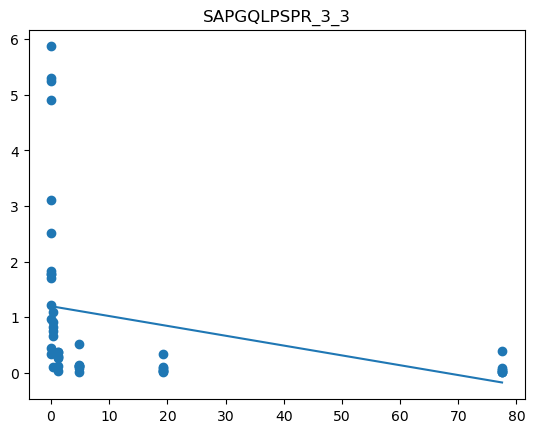

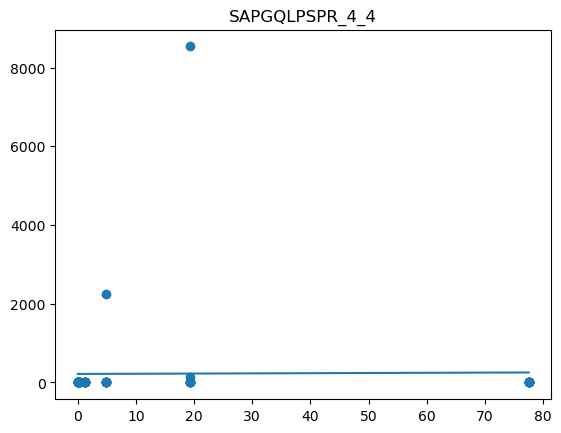

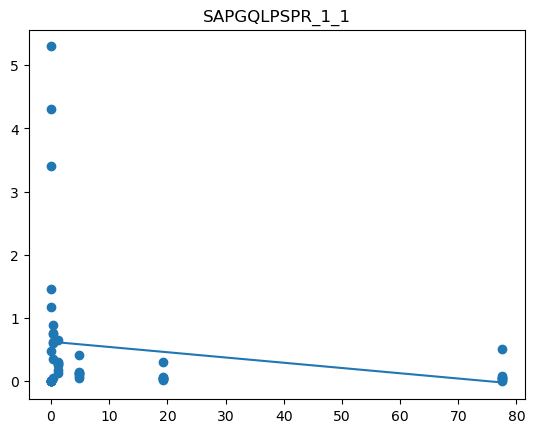

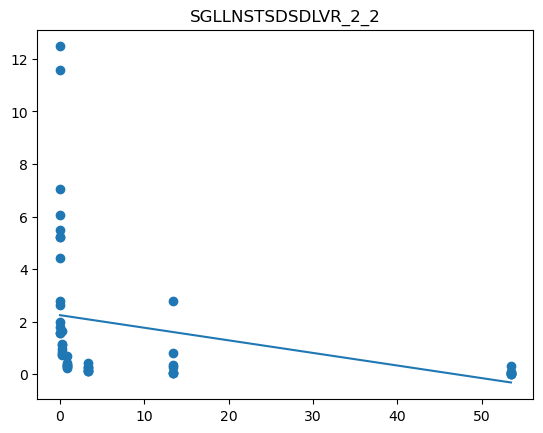

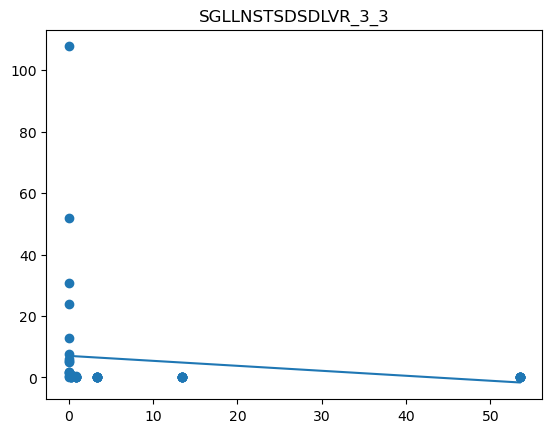

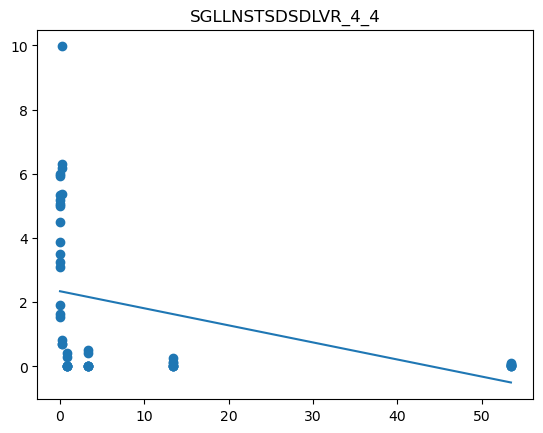

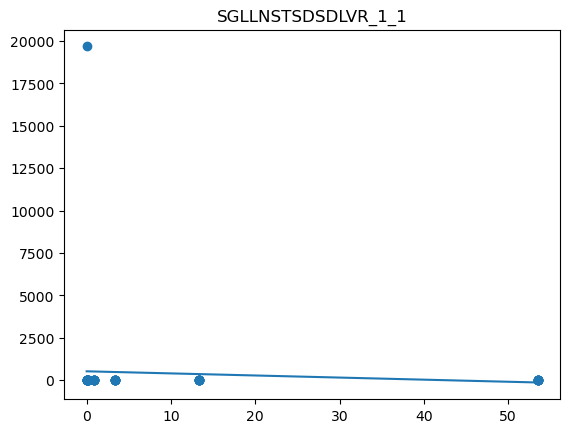

In [30]:
result_data_folder = pathlib.Path("../../reports/ms_work/peggy_2/plots_by_grp_1_over_x_3")

def get_grp_plot(data:pd.DataFrame, plot_grp_cat:str, ax):

    cat_data = data[data['plot_cat_grp'] == plot_grp_cat].copy()
    # print(cat_data)

    # fig, ax = plt.subplots()
    cat_data.dropna(axis=0, inplace=True)

    y = cat_data['area_ratio'].values 
    x = cat_data['heavy_conc'].values

    # non-linear regression
    x = 1/x
    valid_pts = np.where(~np.isnan(x) & ~np.isinf(x))[0]
    x = x[valid_pts]
    y = y[valid_pts]

    ax.scatter(x, y)

    x = x[:, np.newaxis]
    y = y[:, np.newaxis]

    model = linear_model.LinearRegression()
    # print(np.max(x))
    model.fit(x, y)

    y_fit = model.predict(x)

    ax.plot(x.flatten(), y_fit.flatten())
    ax.set_title(plot_grp_cat)
    
    return ax

def get_plot_grp_col(plot_cat:str):

    items = plot_cat.split("_")

    del items[1]
    grp_str = "_".join(items)

    return grp_str

    


plot_df['plot_cat_grp'] = plot_df['plot_cat'].apply(get_plot_grp_col)
plot_cat_grps = plot_df['plot_cat_grp'].unique()


for grp in plot_cat_grps:
    fig, ax = plt.subplots()
    ax = get_grp_plot(data=plot_df, plot_grp_cat=grp, ax=ax)
    fig = plt.gcf()
    fig.savefig(fname=result_data_folder.joinpath(grp))

In [31]:
# merge to assign group properties to individual rows
df_area_ratio_conc_n_fit_params = pd.merge(df_area_ratio_conc,
                                           right=df_plot_cat_fit_params,
                                           on='plot_cat',
                                           how='left')

df_area_ratio_conc_n_fit_params
# save to csv file
# df_area_ratio_conc_n_fit_params.to_csv('area_ratio_conc_n_fit_params.csv', index=False)
    

,peptide,protein,replicate,product charge,fragment ion,area_ratio,area_min,area_max,peptide_dilution_name,Peptides,dilution,heavy_conc,plot_cat,plot_cat_grp,order_comp,rep_partial,R2,intercept,gradient
0,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,b2,0.000000,3.483650e+05,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,D0,0.0000,AHSLNPDASGSSCSLAR_b2_2_2,AHSLNPDASGSSCSLAR_2_2,17,D0_2ul,0.108036,2.3608905654098535,-0.06501598720453211
1,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,b3,0.000000,2.139450e+05,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,D0,0.0000,AHSLNPDASGSSCSLAR_b3_2_2,AHSLNPDASGSSCSLAR_2_2,17,D0_2ul,0.079713,3.064855429936669,-0.08443853859848523
2,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,y10,0.000000,2.493160e+05,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,D0,0.0000,AHSLNPDASGSSCSLAR_y10_2_2,AHSLNPDASGSSCSLAR_2_2,17,D0_2ul,0.125175,2.198931742117608,-0.060479535461833225
3,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,y12,0.000000,1.203510e+06,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,D0,0.0000,AHSLNPDASGSSCSLAR_y12_2_2,AHSLNPDASGSSCSLAR_2_2,17,D0_2ul,0.103836,1.479509996932243,-0.04057244770154918
4,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,2,precursor,0.007892,4.671665e+07,368708.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,D0,0.0000,AHSLNPDASGSSCSLAR_precursor_2_2,AHSLNPDASGSSCSLAR_2_2,17,D0_2ul,0.126493,1.2518001395796483,-0.033990347695454955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,1,y3,0.000000,1.496066e+06,0.0,SGLLNSTSDSDLVR_D7,SGLLNSTSDSDLVR,D7,0.0187,SGLLNSTSDSDLVR_y3_1_1,SGLLNSTSDSDLVR_1_1,8,D7_2ul,0.161385,0.04574287532408918,-0.000848442717749969
1116,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,1,y5,0.007541,3.495830e+06,26362.0,SGLLNSTSDSDLVR_D7,SGLLNSTSDSDLVR,D7,0.0187,SGLLNSTSDSDLVR_y5_1_1,SGLLNSTSDSDLVR_1_1,8,D7_2ul,0.074548,0.22818271605962892,-0.0047077195495484996
1117,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,2,precursor,0.016787,1.812807e+09,30431842.0,SGLLNSTSDSDLVR_D7,SGLLNSTSDSDLVR,D7,0.0187,SGLLNSTSDSDLVR_precursor_1_1,SGLLNSTSDSDLVR_1_1,8,D7_2ul,0.120449,1.6094556104396327,-0.03682154038100393
1118,SGLLNSTSDSDLVR,sp|Q12809|KCNH2_HUMAN,D7_2ul_8,2,precursor [M+1],0.032604,1.304090e+09,42518064.0,SGLLNSTSDSDLVR_D7,SGLLNSTSDSDLVR,D7,0.0187,SGLLNSTSDSDLVR_precursor [M+1]_1_1,SGLLNSTSDSDLVR_1_1,8,D7_2ul,0.128458,1.36518908238323,-0.030868320835965978


In [32]:
q90 = [0.941, 0.765, 0.642, 0.56, 0.507, 0.468, 0.437,
       0.412, 0.392, 0.376, 0.361, 0.349, 0.338, 0.329,
       0.32, 0.313, 0.306, 0.3, 0.295, 0.29, 0.285, 0.281,
       0.277, 0.273, 0.269, 0.266, 0.263, 0.26
      ]

q95 = [0.97, 0.829, 0.71, 0.625, 0.568, 0.526, 0.493, 0.466,
       0.444, 0.426, 0.41, 0.396, 0.384, 0.374, 0.365, 0.356,
       0.349, 0.342, 0.337, 0.331, 0.326, 0.321, 0.317, 0.312,
       0.308, 0.305, 0.301, 0.29
      ]

q99 = [0.994, 0.926, 0.821, 0.74, 0.68, 0.634, 0.598, 0.568,
       0.542, 0.522, 0.503, 0.488, 0.475, 0.463, 0.452, 0.442,
       0.433, 0.425, 0.418, 0.411, 0.404, 0.399, 0.393, 0.388,
       0.384, 0.38, 0.376, 0.372
       ]

Q90 = {n:q for n,q in zip(range(3,len(q90)+1), q90)}
Q95 = {n:q for n,q in zip(range(3,len(q95)+1), q95)}
Q99 = {n:q for n,q in zip(range(3,len(q99)+1), q99)}

def dixon_test(data, left=True, right=True, q_dict=Q95):
    """
    Keyword arguments:
        data = A ordered or unordered list of data points (int or float).
        left = Q-test of minimum value in the ordered list if True.
        right = Q-test of maximum value in the ordered list if True.
        q_dict = A dictionary of Q-values for a given confidence level,
            where the dict. keys are sample sizes N, and the associated values
            are the corresponding critical Q values. E.g.,
            {3: 0.97, 4: 0.829, 5: 0.71, 6: 0.625, ...}

    Returns a list of 2 values for the outliers, or None.
    E.g.,
       for [1,1,1] -> [None, None]
       for [5,1,1] -> [None, 5]
       for [5,1,5] -> [1, None]

    """
    assert(left or right), 'At least one of the variables, `left` or `right`, must be True.'
    assert(len(data) >= 3), 'At least 3 data points are required'
    assert(len(data) <= max(q_dict.keys())), 'Sample size too large'

    sdata = sorted(data)
    Q_mindiff, Q_maxdiff = (0,0), (0,0)

    if left:
        Q_min = (sdata[1] - sdata[0])
        try:
            Q_min /= (sdata[-1] - sdata[0])
        except ZeroDivisionError:
            pass
        Q_mindiff = (Q_min - q_dict[len(data)], sdata[0])

    if right:
        Q_max = abs((sdata[-2] - sdata[-1]))
        try:
            Q_max /= abs((sdata[0] - sdata[-1]))
        except ZeroDivisionError:
            pass
        Q_maxdiff = (Q_max - q_dict[len(data)], sdata[-1])

    if not Q_mindiff[0] > 0 and not Q_maxdiff[0] > 0:
        outliers = [None, None]

    elif Q_mindiff[0] == Q_maxdiff[0]:
        outliers = [Q_mindiff[1], Q_maxdiff[1]]

    elif Q_mindiff[0] > Q_maxdiff[0]:
        outliers = [Q_mindiff[1], None]

    else:
        outliers = [None, Q_maxdiff[1]]

    return outliers


dixon_test([0.142, 0.153, 0.135, 0.002, 0.175], left=False)

[None, None]

# Fit metric

In [33]:
def get_fit_param_cat(row):
    """Get the fit param category (C18_SDS, C18_SDC, etc..)."""

    replicate = row['replicate']
    peptide = row['peptide']

    rep_elements = replicate.split('_')[0:3]

    cat_name = [peptide]  + rep_elements
    cat_name = '_'.join(cat_name)
    return cat_name

def qtest(data, right=True):

    sorted_data = sorted(data)

    if right:
        gap = sorted_data[-1] - sorted_data[-2]

    else:
        gap = sorted_data[1] - sorted_data[0]

    try:
        range = sorted_data[-1] - sorted_data[0]
        q_val = gap / range
    except ZeroDivisionError:
        q_val = gap

    return q_val

def get_grp_fit_agg(grouped_df:pd.DataFrame):
    """Get the aggregate values for each group."""

    df = grouped_df[['intercept', 'gradient', 'R2']].copy()
    gradient = df['gradient'].values
    intercept = df['intercept'].values
    r2 = df['R2'].values

    mean_grad = gradient.mean()
    stdv_grad = gradient.std()
    cov_grad = stdv_grad / mean_grad
    qtest_grad_right = qtest(gradient, right=True)

    mean_intercept = intercept.mean()
    stdv_intercept = intercept.std()
    cov_intercept = stdv_intercept / mean_intercept
    qtest_intercept_right = qtest(intercept, right=True)

    mean_r2 = r2.mean()
    stdv_r2 = r2.std()
    cov_r2 = stdv_r2 / mean_r2
    qtest_r2_right = qtest(r2, right=True)

    cols_dict = {'mean_grad':mean_grad, 'stdv_grad':stdv_grad,
                 'cov_grad':cov_grad, 'qtest_grad':qtest_grad_right, 
                 'mean_intercept':mean_intercept, 'stdv_intercept':stdv_intercept,
                 'cov_intercept':cov_intercept, 'qtest_intercept':qtest_intercept_right,
                 'mean_r2':mean_r2, 'stdv_r2':stdv_r2,
                 'cov_r2':cov_r2, 'qtest_r2':qtest_r2_right
                 }

    return pd.Series(cols_dict)


# create plot categories
temp = df_area_ratio_conc_n_fit_params.copy()
temp['fit_param_grp'] = temp.apply(get_fit_param_cat, axis=1)

cols_to_group_by = ['fit_param_grp']
df_fit_param_agg = temp.groupby(cols_to_group_by).apply(get_grp_fit_agg).reset_index()

df_w_fit_param_agg = pd.merge(left=temp, right=df_fit_param_agg, how='left', on=cols_to_group_by)
df_w_fit_param_agg.head(3)

,peptide,protein,replicate,product charge,fragment ion,area_ratio,area_min,area_max,peptide_dilution_name,Peptides,...,cov_grad,qtest_grad,mean_intercept,stdv_intercept,cov_intercept,qtest_intercept,mean_r2,stdv_r2,cov_r2,qtest_r2
0,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,b2,0.0,348365.0,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,...,-0.391108,0.032116,1.799962,0.696767,0.387101,0.35675,0.109889,0.014548,0.132392,0.028187
1,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,b3,0.0,213945.0,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,...,-0.391108,0.032116,1.799962,0.696767,0.387101,0.35675,0.109889,0.014548,0.132392,0.028187
2,AHSLNPDASGSSCSLAR,sp|Q12809|KCNH2_HUMAN,D0_2ul_17,1,y10,0.0,249316.0,0.0,AHSLNPDASGSSCSLAR_D0,AHSLNPDASGSSCSLAR,...,-0.391108,0.032116,1.799962,0.696767,0.387101,0.35675,0.109889,0.014548,0.132392,0.028187


In [34]:
# The columns that have zero area as denominator
df_w_fit_param_agg[df_w_fit_param_agg.area_ratio.isna()]

,peptide,protein,replicate,product charge,fragment ion,area_ratio,area_min,area_max,peptide_dilution_name,Peptides,...,cov_grad,qtest_grad,mean_intercept,stdv_intercept,cov_intercept,qtest_intercept,mean_r2,stdv_r2,cov_r2,qtest_r2


In [35]:
result_data_folder = pathlib.Path("../../reports/ms_work/peggy_2/")

df_w_fit_param_agg.to_csv(result_data_folder.joinpath('data_with_fit_param_aggregate_peggy_3_1_over_x.csv'), index=False)